In [1]:
import os
import pdb
from math import floor,ceil
import random
from itertools import permutations
from collections import Counter
import winsound

# import gdal
# import osr
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import some_func

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ROC_PATH = r'G:\GIS\script\py\img\auc'

# load data

In [4]:
dtypes = {
    'aspect': np.float32,
    'slope': np.float32,
    'profileCur': np.float32,
    'planCur': np.float32,
    'spi': np.float32,
    'sti': np.float32,
    'twi': np.float32,
    'ndvi': np.float32,
    'landUse': np.uint8,
    'roadKDen': np.float32,
    'riverKDen': np.float32,
    'geo': np.int16,
    'target': np.int16
}

In [5]:
dataframe = pd.read_csv(r'G:\GIS\script\py\dataframe_ori.csv', index_col=0, dtype = dtypes)

In [6]:
X, y = dataframe[dataframe.columns[0:-1]], dataframe['target']

## drop na

In [7]:
for item in X.columns.to_list():
    item_min = X[item].min()
    X.loc[X[item] == item_min, item] = np.NaN
X.dropna(inplace=True)

## Feature Columns

### Number

In [9]:
feature_columns = []
number_columns = []
headers = dataframe.columns[:-1]

for header in headers:
    feature_columns.append(feature_column.numeric_column(header))

In [10]:
def get_onehot(X, feature_columns, batch_size=2**15):
    feature_layer = layers.DenseFeatures(feature_columns)
    length = len(X)
    num = length // batch_size
    x_onehot = feature_layer(dict(X[num * batch_size: length])).numpy()
    for i in range(num):
#         print(i)
        x_onehot_batch = feature_layer(dict(X[i * batch_size:(i + 1) * batch_size])).numpy()
        x_onehot = np.r_[x_onehot, x_onehot_batch]
    _, column_num = x_onehot.shape
    return x_onehot, column_num

In [12]:
X_onehot, columns_num = get_onehot(X, feature_columns)

In [13]:
column_names = ['aspect', 'geo', 'landUse', 'ndvi', 'planCur', 'profileCur',
                'riverKDen', 'roadKDen', 'slope', 'spi', 'sti', 'twi', 'target']

In [14]:
X_index = X.index
dataframe_onehot = pd.DataFrame(np.c_[X_onehot, y[X_index]], index=X_index, columns=column_names)

In [15]:
postive_frame_onehot_all = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot_all = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

In [16]:
postive_frame_onehot, postive_frame_onehot_vala = train_test_split(postive_frame_onehot_all, test_size=0.2)
negative_frame_onehot, negative_frame_onehot_vala = train_test_split(negative_frame_onehot_all, test_size=0.2)
postive_frame_onehot_val, postive_frame_onehot_test = train_test_split(postive_frame_onehot_vala, test_size=0.5)
negative_frame_onehot_val, negative_frame_onehot_test = train_test_split(negative_frame_onehot_vala, test_size=0.5)

In [17]:
data_train = np.r_[postive_frame_onehot, negative_frame_onehot]
data_val = np.r_[postive_frame_onehot_val, negative_frame_onehot_val]
data_test = np.r_[postive_frame_onehot_test, negative_frame_onehot_test]

In [18]:
# del dataframe, X, y

## under sampling

### kmeans

In [19]:
from sklearn.cluster import KMeans, MiniBatchKMeans
batch_size = 2**15
def cluster_under_sample(k, negative_frame_onehot, batch_size=batch_size):
    #     kmeans = KMeans(n_clusters=k, max_iter=300, random_state=8)
    kmeans = MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=batch_size,
                             n_init=3, max_no_improvement=10, verbose=0)
    kmeans.fit(negative_frame_onehot[negative_frame_onehot.columns[0:-1]])
    return kmeans.cluster_centers_

### Random

In [20]:
def random_under_sample(k, negative_frame_onehot):
    if isinstance(negative_frame_onehot, pd.core.frame.DataFrame):
        negative_frame_onehot = negative_frame_onehot.to_numpy()
    length = len(negative_frame_onehot)
    index = np.random.choice(range(length), k, replace=False)
#     pdb.set_trace()
    return negative_frame_onehot[index, 0:-1]

In [21]:
UNDER_SAMPLE = {
    1: cluster_under_sample,
    0: random_under_sample,
}

### merge postive and negative

#### random

In [22]:
new_negative = random_under_sample(len(postive_frame_onehot_all), negative_frame_onehot_all)

In [23]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], postive_frame_onehot_all.to_numpy()]

In [24]:
data_resample_train, data_resample_v = train_test_split(data_target_resample, test_size=0.3)
data_resample_val, data_resample_test = train_test_split(data_resample_v, test_size=0.5)

#### k means

In [24]:
new_negative = cluster_under_sample(len(postive_frame_onehot_all), negative_frame_onehot_all)

In [25]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], postive_frame_onehot_all.to_numpy()]

In [26]:
data_resample_train, data_resample_v = train_test_split(data_target_resample, test_size=0.3)
data_resample_val, data_resample_test = train_test_split(data_resample_v, test_size=0.5)

## metrics

In [25]:
def get_gmean(y_true, y_pred, beta=1):
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true must have same shape with y_pred")
    length = len(y_true)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(length):
        if y_pred[i]:
            if y_true[i]:
                tp += 1
            else:
                fp += 1
        else:
            if y_true[i]:
                fn += 1
            else:
                tn += 1
    pred_postive = tp + fp
    pred_postive = pred_postive if pred_postive else 1
    tp = tp if tp else 1e-6
    precision = tp / pred_postive
    tpr = recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    fbeta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    fpr = fp / (tn + fp)
    tnr = tn/(tn+fp)
    g_mean = np.sqrt(recall * tnr)
    return {'g_mean': g_mean, 'recall': recall, 'tnr': tnr, 'f1': fbeta, 'precision':precision}

In [26]:
def get_auc(y_true, y_pred):
    auc = keras.metrics.AUC()
    auc.update_state(y_true, y_pred)
    return auc.result().numpy()

In [28]:
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_prob):
    auc = get_auc(y_true, y_prob)
    fpr, tpr, thresh = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5, 5))
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr)
    plt.savefig(os.path.join(ROC_PATH,'roc_{:.4f}.png'.format(auc)))

## learner

In [29]:
def test_learner(learner, data):
    # learner must be trained
    y_prob = learner.predict_proba(data[:, 0:-1])[:, 1]
    y_pred = learner.predict(data[:, 0:-1]).flatten()
    y_true = data[:, -1]
    print(get_gmean(y_true, y_pred))
    auc = get_auc(y_true, y_prob)
#     pdb.set_trace()
    print('auc:{}'.format(auc))
    plot_roc(y_true, y_prob)
    return y_true, y_pred, y_prob

### SGD

In [30]:
from sklearn.linear_model import SGDClassifier

{'g_mean': 4.2298991947776476e-05, 'recall': 1.7953321332220248e-09, 'tnr': 0.9965870307167235, 'f1': 3.577817524905514e-09, 'precision': 5e-07}
auc:0.49829351902008057
{'g_mean': 4.2298991947776476e-05, 'recall': 1.7953321332220248e-09, 'tnr': 0.9965870307167235, 'f1': 3.577817524905514e-09, 'precision': 5e-07}
auc:0.49829351902008057
{'g_mean': 4.2298991947776476e-05, 'recall': 1.7953321332220248e-09, 'tnr': 0.9965870307167235, 'f1': 3.577817524905514e-09, 'precision': 5e-07}
auc:0.49829351902008057
{'g_mean': 4.2298991947776476e-05, 'recall': 1.7953321332220248e-09, 'tnr': 0.9965870307167235, 'f1': 3.577817524905514e-09, 'precision': 5e-07}
auc:0.49829351902008057
{'g_mean': 4.2298991947776476e-05, 'recall': 1.7953321332220248e-09, 'tnr': 0.9965870307167235, 'f1': 3.577817524905514e-09, 'precision': 5e-07}
auc:0.49829351902008057
{'g_mean': 4.2298991947776476e-05, 'recall': 1.7953321332220248e-09, 'tnr': 0.9965870307167235, 'f1': 3.577817524905514e-09, 'precision': 5e-07}
auc:0.4982

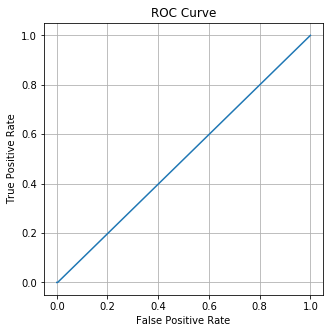

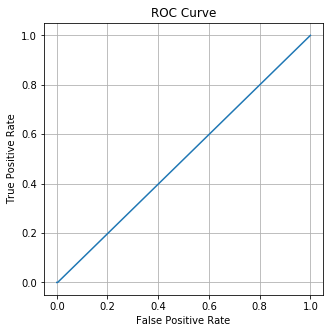

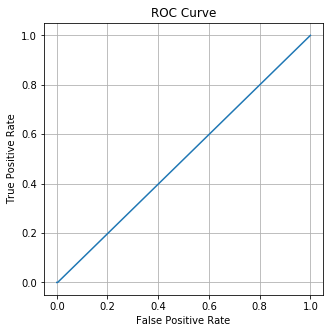

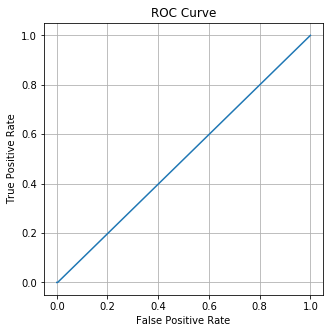

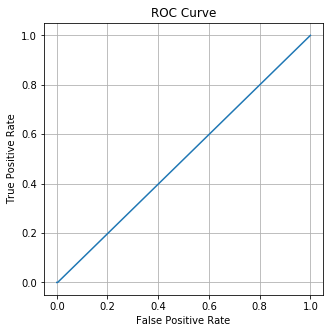

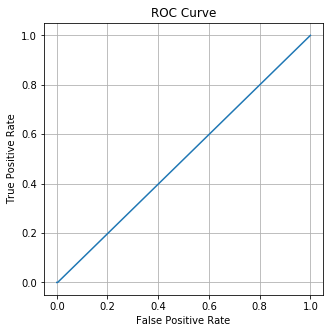

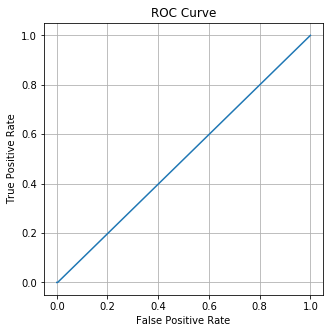

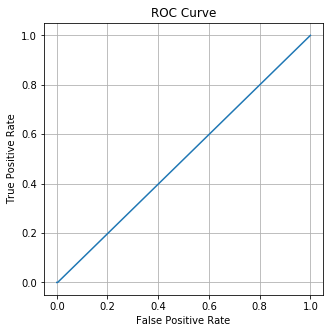

In [31]:
losses = ['log', 'modified_huber']
penaltys = ['none', 'l2', 'l1', 'elasticnet']

for los in losses:
    for penalty in penaltys:
        sgd = SGDClassifier(loss=los, penalty=penalty, alpha=10**-50, l1_ratio=0.15, random_state=8, )
        sgd.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])
        y_true, y_pred, y_prob=test_learner(sgd, data_resample_val)

### DT

In [32]:
from sklearn.tree import DecisionTreeClassifier

{'g_mean': 0.7540004887463918, 'recall': 0.7989228007181328, 'tnr': 0.71160409556314, 'f1': 0.7600341588385994, 'precision': 0.7247557003257329}
auc:0.8034341931343079


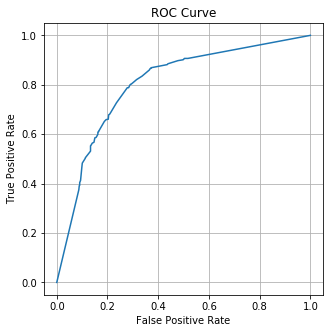

In [33]:
# for i in range(11,18):
# print(i)
dtc = DecisionTreeClassifier(
    criterion='gini', max_depth=14, random_state=8)
dtc.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

y_true, y_pred, y_prob=test_learner(dtc, data_resample_val)

In [36]:
fpr_DT, tpr_DT, thresh_DT = roc_curve(y_true, y_prob)

### ET

In [37]:
from sklearn.tree import ExtraTreeClassifier

{'g_mean': 0.6581272955775413, 'recall': 0.6768402154398564, 'tnr': 0.6399317406143344, 'f1': 0.6585152838427948, 'precision': 0.641156462585034}
auc:0.7193966507911682


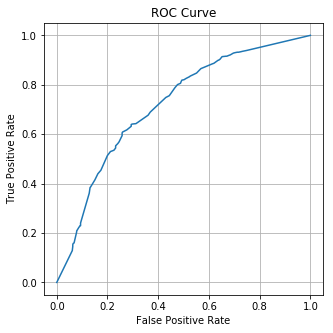

In [38]:
# for i in range(1,20):
#     print(i)
etc = ExtraTreeClassifier(criterion='gini', max_depth=15, random_state=8)
etc.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

y_true, y_pred, y_prob=test_learner(etc, data_resample_val)

In [39]:
fpr_ET, tpr_ET, thresh_ET = roc_curve(y_true, y_prob)

### LR

In [48]:
from sklearn.linear_model import LogisticRegression

{'g_mean': 0.568796458994521, 'recall': 0.4230769230769231, 'tnr': 0.7647058823529411, 'f1': 0.4888888888888889, 'precision': 0.5789473684210527}
auc:0.7220022678375244


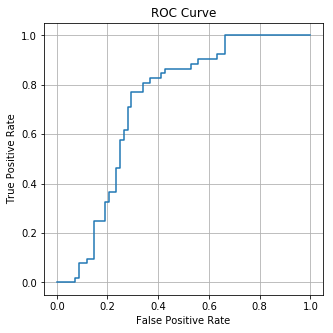

In [200]:
lr = LogisticRegression(random_state=0, C=1, tol = 1)
lr.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

y_true, y_pred, y_prob=test_learner(lr, data_resample_val)

### SVC

In [30]:
from sklearn.svm import SVC, NuSVC

{'g_mean': 0.8760901418527569, 'recall': 0.8846153846153846, 'tnr': 0.8676470588235294, 'f1': 0.8598130841121494, 'precision': 0.8363636363636363}
auc:0.9565894603729248


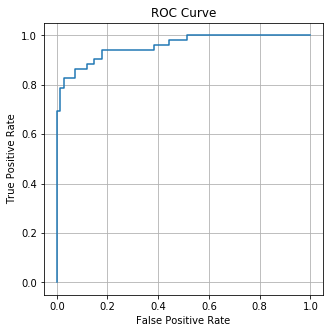

In [202]:
svc = SVC(C=0.1, kernel='linear', degree=3, gamma='auto_deprecated', probability=True, random_state=6)
svc.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

y_true, y_pred, y_prob=test_learner(svc, data_resample_val)

### GaussianNB

In [53]:
from sklearn.naive_bayes import GaussianNB

{'g_mean': 0.7735737130957593, 'recall': 0.8846153846153846, 'tnr': 0.6764705882352942, 'f1': 0.7666666666666666, 'precision': 0.6764705882352942}
auc:0.910633385181427


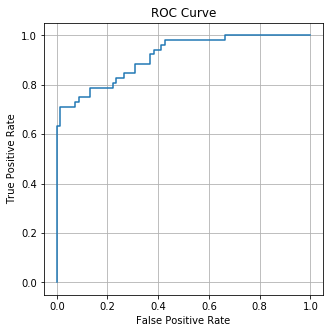

In [208]:
gnb = GaussianNB(var_smoothing=0.00001)
gnb.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

y_true, y_pred, y_prob=test_learner(gnb, data_resample_val)

## RF

In [55]:
from sklearn.ensemble import RandomForestClassifier

66 32
{'g_mean': 0.9926198253344827, 'recall': 1.0, 'tnr': 0.9852941176470589, 'f1': 0.9904761904761905, 'precision': 0.9811320754716981}
auc:1.0


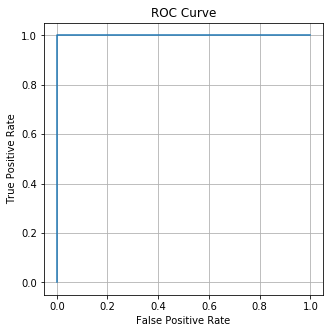

In [209]:
# for i in range(10,100):
# for j in range(22,100):
rf = RandomForestClassifier(n_estimators=66, max_depth=32, random_state=8)
print(rf.n_estimators, rf.max_depth)
rf.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

y_true, y_pred, y_prob=test_learner(rf, data_resample_val)

##  GradientBoosting

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

30 13
{'g_mean': 0.9733438190306902, 'recall': 0.9615384615384616, 'tnr': 0.9852941176470589, 'f1': 0.970873786407767, 'precision': 0.9803921568627451}
auc:0.9913744330406189


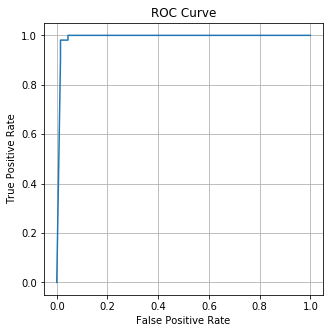

In [210]:
# aucs = np.zeros((50,50))
# for i in tqdm(range(3,50)):
#     for j in range(3,50):
gb = GradientBoostingClassifier(n_estimators=30, max_depth=13, random_state=0)
print(gb.n_estimators, gb.max_depth)
gb.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

# y_prob = gb.predict_proba(X=data_resample_val[:, :-1])[:, 1]
# y_true = data_resample_val[:, -1]
# aucs[i,j] = get_auc(y_true, y_prob)

y_true, y_pred, y_prob=test_learner(gb, data_resample_val)

## AdaBoost

In [78]:
import inspect
from sklearn.utils.testing import all_estimators
for name, clf in all_estimators(type_filter='classifier'):
    if 'sample_weight' in inspect.getargspec(clf().fit)[0]:
       print(name)

AdaBoostClassifier
BaggingClassifier
BernoulliNB
CalibratedClassifierCV


TypeError: __init__() missing 1 required positional argument: 'base_estimator'

In [59]:
from sklearn.ensemble import AdaBoostClassifier

In [213]:
algorithm_ada = ['SAMME', 'SAMME.R']
base_estimators = [
#     MLPClassifier(hidden_layer_sizes=(64), activation='relu', random_state=0,
#                   solver='sgd', alpha=1e-5, max_iter=500, early_stopping=True),
    DecisionTreeClassifier(
        criterion='gini', max_depth=14, random_state=8),
    ExtraTreeClassifier(criterion='gini', max_depth=15, random_state=8),
#     LogisticRegression(C=10**-50, tol = 1, random_state=0),
#     KNeighborsClassifier(n_neighbors=70),
    SVC(C=1.0, kernel='linear', degree=3, gamma='auto_deprecated', probability=True,),
    GaussianNB(var_smoothing=0.001),
]

In [ ]:
# for alg in algorithm_ada:
for estimator in base_estimators:
#         for n_est in range(90, 131):
# 101，DT，SAMME：0.8325
# 101, ET, samme: 0.8314
    ada = AdaBoostClassifier(base_estimator=estimator, n_estimators=50,
                             learning_rate=1.0, algorithm=algorithm_ada[0], random_state=8)
    print(ada.n_estimators, ada.base_estimator.__class__, ada.algorithm)
    ada.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

    y_true, y_pred, y_prob = test_learner(ada, data_resample_val)

50 <class 'sklearn.tree.tree.DecisionTreeClassifier'> SAMME
{'g_mean': 0.9660527514333968, 'recall': 0.9615384615384616, 'tnr': 0.9705882352941176, 'f1': 0.9615384615384616, 'precision': 0.9615384615384616}
auc:0.9660632610321045
50 <class 'sklearn.tree.tree.ExtraTreeClassifier'> SAMME
{'g_mean': 0.9471318934179187, 'recall': 1.0, 'tnr': 0.8970588235294118, 'f1': 0.936936936936937, 'precision': 0.8813559322033898}
auc:0.9901018142700195
50 <class 'sklearn.svm.classes.SVC'> SAMME


## Bagging

In [74]:
bagging_base_estimators = [
    MLPClassifier(hidden_layer_sizes=(64), activation='relu', random_state=0,
                  solver='sgd', alpha=1e-5, max_iter=500, early_stopping=True),
    DecisionTreeClassifier(
        criterion='gini', max_depth=14, random_state=8),
    ExtraTreeClassifier(criterion='gini', max_depth=15, random_state=8),
    LogisticRegression(C=10**-22, tol = 1, random_state=0),
    KNeighborsClassifier(n_neighbors=70),
    GaussianNB(var_smoothing=1000),
]

17 <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
{'g_mean': 0.040723148118768406, 'recall': 1.0, 'tnr': 0.001658374792703151, 'f1': 0.6420927467300832, 'precision': 0.47285464098073554}
auc:0.4983416199684143
17 <class 'sklearn.tree.tree.DecisionTreeClassifier'>
{'g_mean': 0.8235821601232706, 'recall': 0.8592592592592593, 'tnr': 0.7893864013266998, 'f1': 0.8205128205128206, 'precision': 0.7851099830795262}
auc:0.8983446955680847
17 <class 'sklearn.tree.tree.ExtraTreeClassifier'>
{'g_mean': 0.7349622594096838, 'recall': 0.7222222222222222, 'tnr': 0.7479270315091211, 'f1': 0.7208872458410351, 'precision': 0.7195571955719557}
auc:0.8191327452659607
17 <class 'sklearn.linear_model.logistic.LogisticRegression'>
{'g_mean': 4.303314825134801e-05, 'recall': 1.8518518484224964e-09, 'tnr': 1.0, 'f1': 3.6968576641462882e-09, 'precision': 1e-06}
auc:0.5
17 <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
{'g_mean': 0.5160705858497112, 'recall': 0.4851851851851

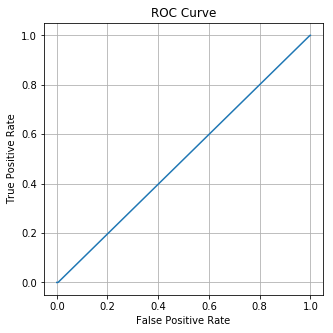

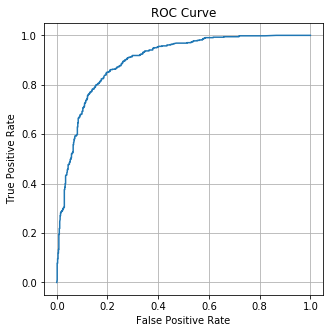

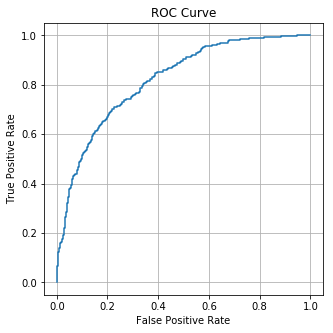

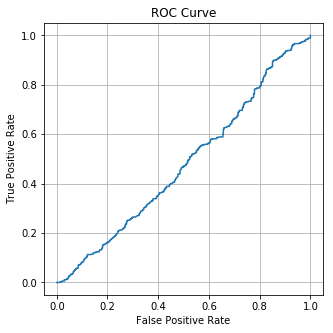

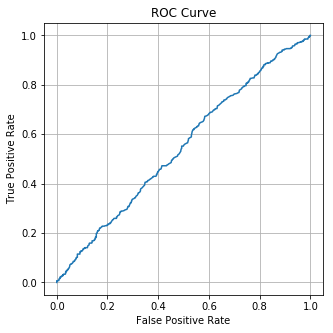

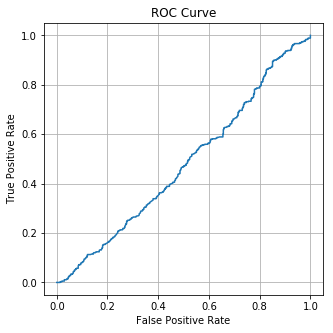

In [75]:
from sklearn.ensemble import BaggingClassifier

for estimator in bagging_base_estimators:
#     for n_est in range(1, 60):
    bagging = BaggingClassifier(base_estimator=estimator, n_estimators=17,
                                random_state=8)
    print(bagging.n_estimators, bagging.base_estimator.__class__)
    bagging.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

    y_true, y_pred, y_prob = test_learner(bagging, data_resample_val)

## ROC

In [ ]:
fpr, tpr, thresh = roc_curve(y_true, y_prob)
plt.figure(figsize=(5, 5))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr)
plt.show()

# 斜坡单元

In [42]:
dataframe_xiepo = pd.read_csv(r'G:\GIS\script\py\all_data.csv', index_col=0)

In [43]:
dataframe_xiepo['aspect'] = dataframe_xiepo['aspect'].astype('object')
dataframe_xiepo['landuse'] = dataframe_xiepo['landuse'].astype('object')

In [35]:
min_max_scaler = preprocessing.MinMaxScaler()
dataframe_xiepo = pd.DataFrame(min_max_scaler.fit_transform(dataframe_xiepo), columns=dataframe_xiepo.columns)

In [44]:
dataframe_xiepo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8716 entries, 0 to 8744
Data columns (total 16 columns):
aspect            8716 non-null object
slope             8716 non-null float64
plancur           8716 non-null float64
profile           8716 non-null float64
ndvi              8716 non-null float64
landuse           8716 non-null object
TRI               8716 non-null float64
dem_std           8716 non-null float64
dem_mean          8716 non-null float64
flowacc           8716 non-null float64
distance_HYDL     8716 non-null float64
distance_LRRDL    8716 non-null float64
distance_fault    8716 non-null float64
SPI               8716 non-null float64
TWI               8716 non-null float64
target            8716 non-null int64
dtypes: float64(13), int64(1), object(2)
memory usage: 1.1+ MB


In [45]:
dataframe_xiepo_onehot = pd.get_dummies(dataframe_xiepo)

In [64]:
min_max_scaler = preprocessing.MinMaxScaler()
dataframe_xiepo_onehot = pd.DataFrame(min_max_scaler.fit_transform(
    dataframe_xiepo_onehot), columns=dataframe_xiepo_onehot.columns)

In [46]:
X, y = dataframe_xiepo_onehot.drop(columns=['target']), dataframe_xiepo_onehot['target']

In [8]:
feature_columns = []
number_columns = []
headers = X.columns

for header in headers:
    feature_columns.append(feature_column.numeric_column(header))

In [9]:
# X_onehot, columns_num = get_onehot(X, feature_columns)
X_onehot = X.to_numpy()

In [47]:
postive_frame_onehot_all = dataframe_xiepo_onehot[dataframe_xiepo_onehot['target'] == 1]
negative_frame_onehot_all = dataframe_xiepo_onehot[dataframe_xiepo_onehot['target'] != 1]

In [10]:
# postive_frame_onehot, postive_frame_onehot_vala = train_test_split(postive_frame_onehot_all, test_size=0.2)
# negative_frame_onehot, negative_frame_onehot_vala = train_test_split(negative_frame_onehot_all, test_size=0.2)
# postive_frame_onehot_val, postive_frame_onehot_test = train_test_split(postive_frame_onehot_vala, test_size=0.5)
# negative_frame_onehot_val, negative_frame_onehot_test = train_test_split(negative_frame_onehot_vala, test_size=0.5)

In [11]:
# data_train = np.r_[postive_frame_onehot, negative_frame_onehot]
# data_val = np.r_[postive_frame_onehot_val, negative_frame_onehot_val]
# data_test = np.r_[postive_frame_onehot_test, negative_frame_onehot_test]

## under sampling

### kmeans

In [11]:
from sklearn.cluster import KMeans, MiniBatchKMeans
batch_size = 2**15
def cluster_under_sample(k, negative_frame_onehot, batch_size=batch_size):
    #     kmeans = KMeans(n_clusters=k, max_iter=300, random_state=8)
    kmeans = MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=batch_size,
                             n_init=3, max_no_improvement=10, verbose=0)
    kmeans.fit(negative_frame_onehot)
    return kmeans.cluster_centers_

### Random

In [236]:
def random_under_sample(k, negative_frame_onehot):
    if isinstance(negative_frame_onehot, pd.core.frame.DataFrame):
        negative_frame_onehot = negative_frame_onehot.to_numpy()
    length = len(negative_frame_onehot)
    index = np.random.choice(range(length), k, replace=False)
#     pdb.set_trace()
    return negative_frame_onehot[index, :]

In [237]:
UNDER_SAMPLE = {
    1: cluster_under_sample,
    0: random_under_sample,
}

### merge postive and negative

In [48]:
__ = postive_frame_onehot_all.pop('target')

In [ ]:
__ = negative_frame_onehot_all.pop('target')

#### random

In [24]:
new_negative = random_under_sample(len(postive_frame_onehot_all), negative_frame_onehot_all)

#### k means

In [77]:
new_negative = cluster_under_sample(len(postive_frame_onehot_all), negative_frame_onehot_all)

In [25]:
new_negative.shape

(400, 15)

#### 手动欠采样

In [49]:
_ = negative_frame_onehot_all[negative_frame_onehot_all['target']==-1]
__ = _.pop('target')
new_negative = _.to_numpy()

In [50]:
new_negative.shape

(400, 27)

#### 不采样

In [194]:
new_negative = negative_frame_onehot_all.to_numpy()

In [14]:
dataframe_xiepo_onehot.astype?

In [22]:
np.dtype(np.bool_)

dtype('bool')

In [65]:
dataframe_xiepo_onehot['target'] = dataframe_xiepo_onehot['target'].astype(np.bool_).astype(np.int)

In [66]:
data_target_resample = dataframe_xiepo_onehot.copy()

In [67]:
data_target_resample['landslide'] = dataframe_xiepo_onehot['target']
data_target_resample = data_target_resample.drop(columns=['target'])

In [69]:
data_target_resample = data_target_resample.to_numpy()

#### 混合

In [51]:
data_target_resample = np.r_[
    np.c_[new_negative, np.zeros(len(new_negative))], np.
    c_[postive_frame_onehot_all.to_numpy(),
       np.ones(len(postive_frame_onehot_all))]]

In [52]:
kf = KFold(n_splits=5, random_state=8, shuffle=True)
kf.get_n_splits(data_target_resample)

5

## feature selection

In [15]:
weight_relief = some_func.relief_fit(data_target_resample[:,:-1], data_target_resample[:,-1], 1.0)

TypeError: '(slice(None, None, None), slice(None, -1, None))' is an invalid key

In [17]:
weight_relief

array([ 2.32750000e+00,  3.70029670e+01,  1.02205992e-03, -1.84867791e-04,
        1.36711171e-02,  3.08750000e-01,  2.77528635e-03,  3.10098571e+03,
        4.36079250e+05,  2.43019523e+06,  5.98529807e+05,  6.11001744e+05,
        7.09545116e+05,  1.68920749e+04,  7.64526095e+00])

In [203]:
weight_relief

array([6.69207492e-03, 3.95971490e-03, 3.28908953e-04, 4.27721317e-04,
       4.74579823e-03, 4.45813938e-03, 1.88919523e-03, 5.58014077e-03,
       2.79131454e-02, 2.84945951e-04, 1.65413840e-02, 1.26903703e-02,
       8.68379968e-03, 1.99676053e-04, 1.97061380e-09, 2.82096145e-01])

In [197]:
weight_relief

array([4.28125000e+00, 3.52079631e+01, 1.99514908e-03, 8.41737306e-04,
       1.42759679e-02, 8.76250000e-01, 3.66203904e-03, 3.16210443e+03,
       4.62742663e+05, 4.10859259e+06, 5.81943602e+05, 4.76838625e+05,
       7.57836119e+05, 2.38972483e+05, 2.33048708e+00])

In [132]:
# data_resample_train, data_resample_v = train_test_split(data_target_resample, test_size=0.3)
# data_resample_val, data_resample_test = train_test_split(data_resample_v, test_size=0.5)

## metrics

In [14]:
def get_gmean(y_true, y_pred, beta=1):
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true must have same shape with y_pred")
    length = len(y_true)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(length):
        if y_pred[i]:
            if y_true[i]:
                tp += 1
            else:
                fp += 1
        else:
            if y_true[i]:
                fn += 1
            else:
                tn += 1
    pred_postive = tp + fp
    pred_postive = pred_postive if pred_postive else 1
    tp = tp if tp else 1e-6
    precision = tp / pred_postive
    tpr = recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    fbeta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    fpr = fp / (tn + fp)
    tnr = tn/(tn+fp)
    g_mean = np.sqrt(recall * tnr)
    return {'g_mean': g_mean, 'recall': recall, 'tnr': tnr, 'f1': fbeta, 'precision':precision}

In [15]:
def get_auc(y_true, y_prob):
    auc = keras.metrics.AUC()
    auc.update_state(y_true, y_prob)
    return auc.result().numpy()

In [16]:
def plot_roc(y_true, y_prob, title):
    auc = get_auc(y_true, y_prob)
    fpr, tpr, thresh = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5, 5))
    plt.title('{} ROC Curve'.format(title))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr)
    plt.savefig(os.path.join(ROC_PATH,'roc_{:.4f}.png'.format(auc)))

## learner

In [17]:
def test_learner(learner, data, title):
    # learner must be trained
    y_prob = learner.predict_proba(data[:, 0:-1])[:, 1]
    y_pred = learner.predict(data[:, 0:-1]).flatten()
    y_true = data[:, -1]
#     print(get_gmean(y_true, y_pred))
    auc = get_auc(y_true, y_pred)
#     pdb.set_trace()
    print('auc:{}'.format(auc))
    plot_roc(y_true, y_prob, title)
    return y_true, y_pred, y_prob

### SGD

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data_target_resample = scaler.fit_transform(data_target_resample)

auc:0.805820643901825
auc:0.8268499970436096
auc:0.8986867070198059
auc:0.8488125205039978
auc:0.844298243522644
auc:0.879375696182251
auc:0.8984915018081665
auc:0.8623930215835571
auc:0.8762322068214417
auc:0.8903517127037048


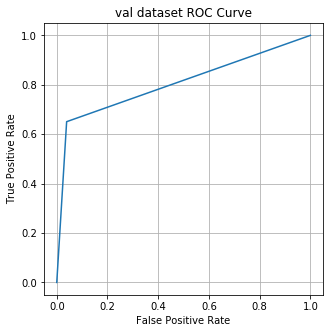

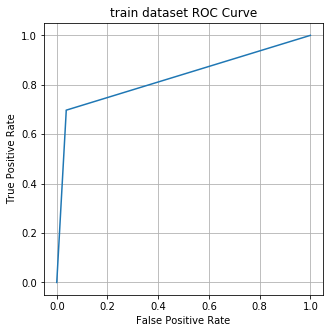

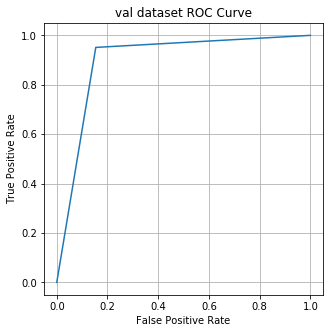

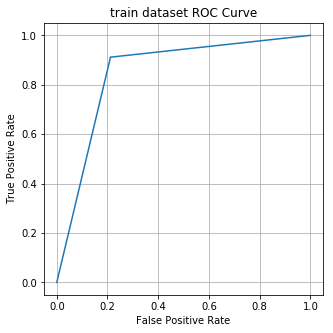

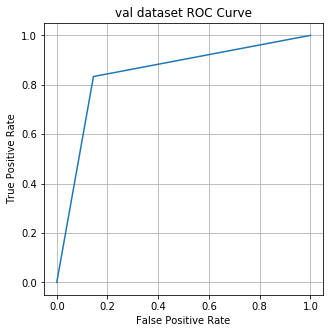

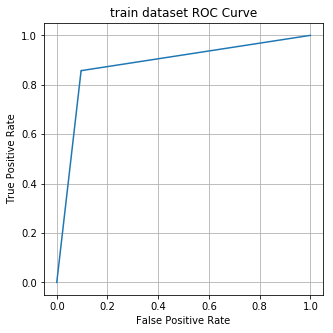

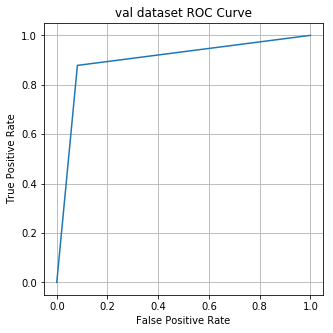

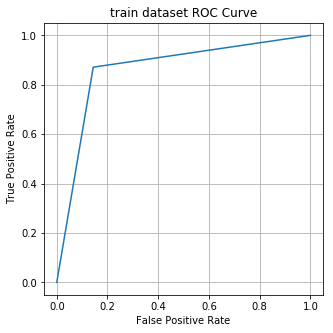

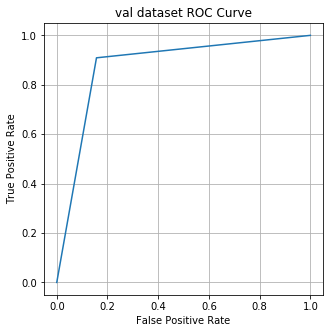

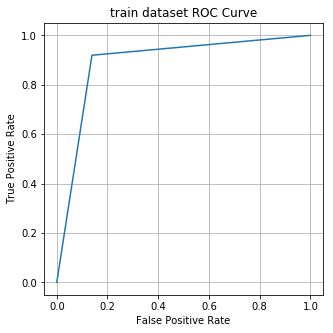

In [30]:
losses = ['log', 'modified_huber']
penaltys = ['none', 'l2', 'l1', 'elasticnet']

# for los in losses:
#     for penalty in penaltys:
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.01, l1_ratio=0.15, random_state=8, )
    sgd.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])
    y_true, y_pred, y_prob=test_learner(sgd, data_resample_val, title='val dataset')
    _,_,_ = test_learner(sgd, data_resample_train, title='train dataset')

### DT

In [31]:
from sklearn.tree import DecisionTreeClassifier

auc:0.9448443055152893
auc:1.0
auc:0.9371482729911804
auc:1.0
auc:0.8793860077857971
auc:1.0
auc:0.9487743377685547
auc:1.0
auc:0.9559537172317505
auc:1.0


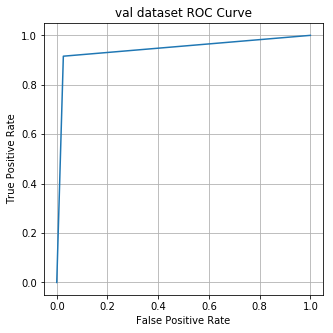

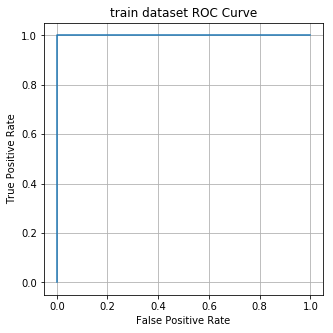

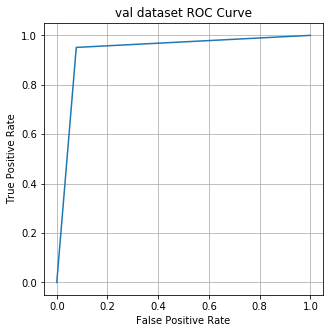

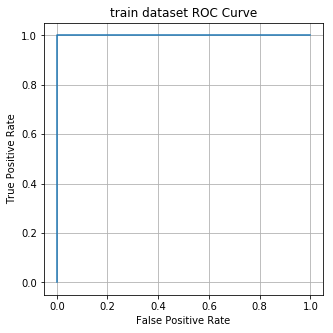

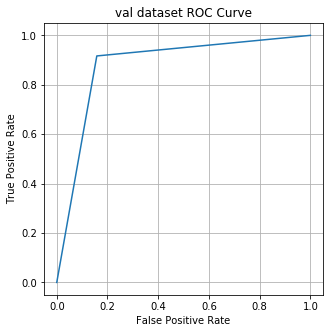

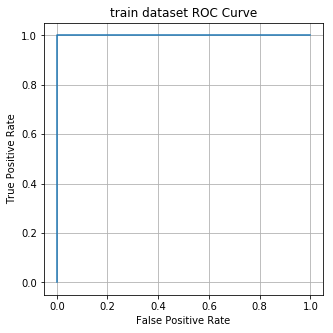

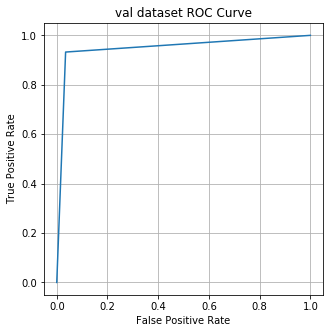

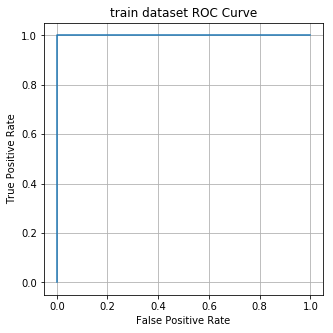

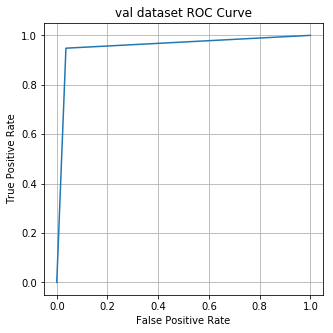

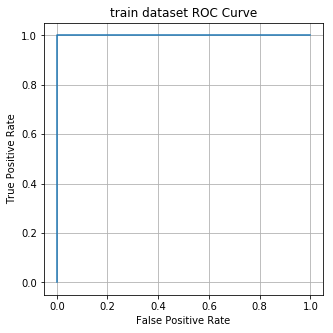

In [33]:
# for i in range(11,18):
# print(i)
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    dtc = DecisionTreeClassifier(
        criterion='gini', max_depth=20, random_state=8)
    dtc.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

    y_true, y_pred, y_prob=test_learner(dtc, data_resample_val, title='val dataset')
    _,_,_ = test_learner(dtc, data_resample_train, title='train dataset')

### ET

In [64]:
from sklearn.tree import ExtraTreeClassifier

auc:0.5165877938270569
auc:0.5308671593666077
auc:0.5047110319137573
auc:0.5333834290504456
auc:0.5040796995162964
auc:0.5370466709136963
auc:0.522230863571167
auc:0.5354856252670288
auc:0.5220113396644592
auc:0.5623056292533875


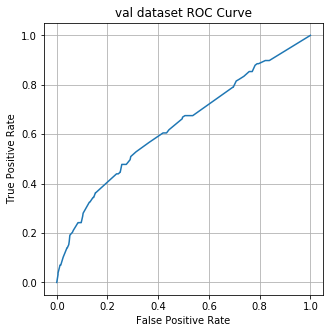

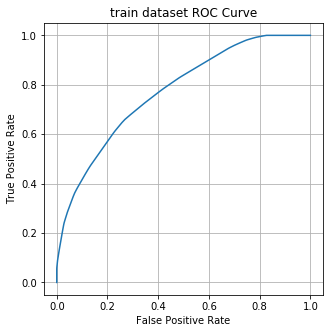

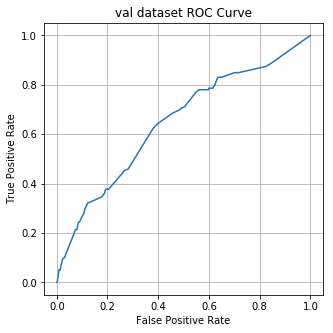

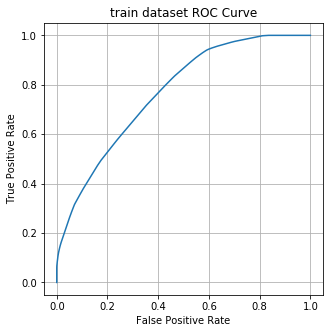

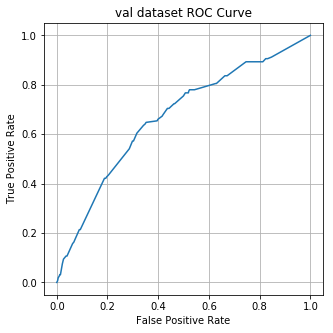

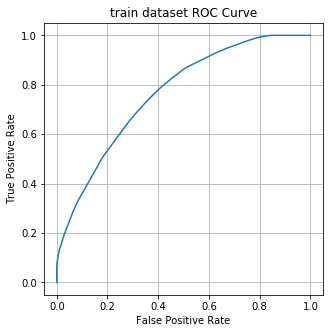

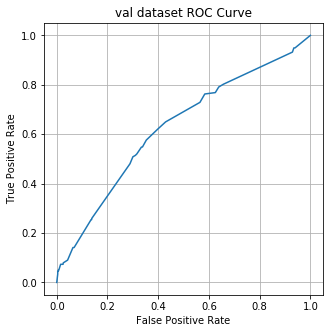

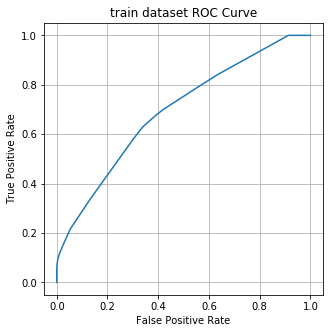

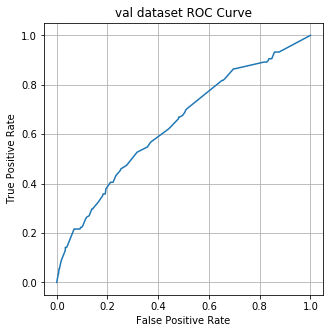

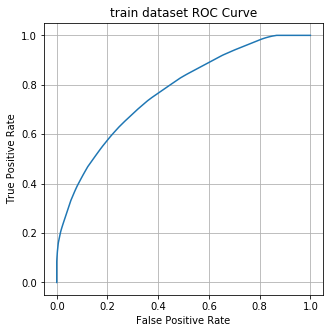

In [65]:
# for i in range(1,20):
#     print(i)
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    etc = ExtraTreeClassifier(criterion='gini', max_depth=10, random_state=8)
    etc.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

    y_true, y_pred, y_prob=test_learner(etc, data_resample_val, title='val dataset')
    _,_,_ = test_learner(etc, data_resample_train, title='train dataset')

### LR

In [66]:
from sklearn.linear_model import LogisticRegression

In [41]:
LogisticRegression?

auc:0.5025545954704285
auc:0.502873420715332
auc:0.5
auc:0.5006220936775208
auc:0.5
auc:0.5014021396636963
auc:0.5021862983703613
auc:0.5
auc:0.5
auc:0.5012964010238647


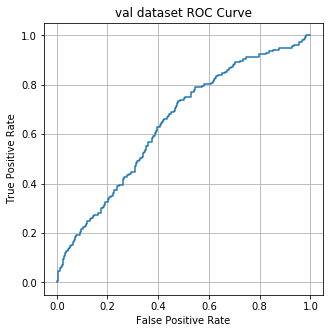

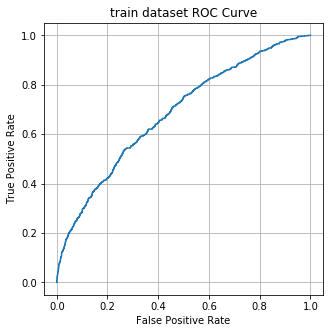

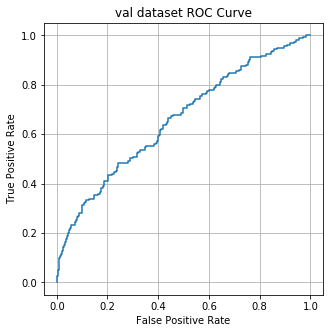

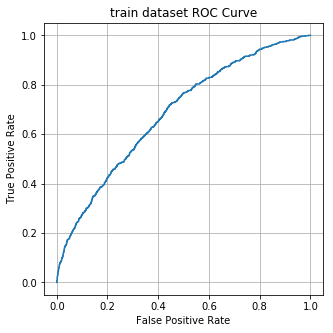

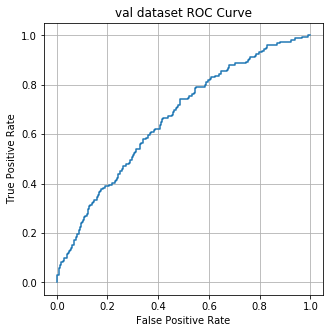

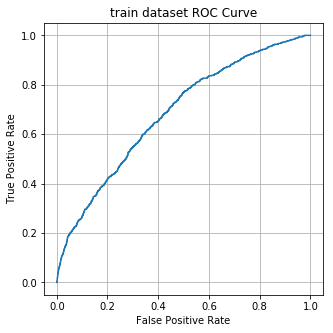

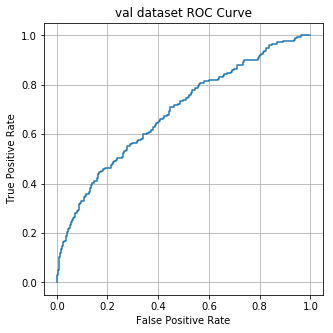

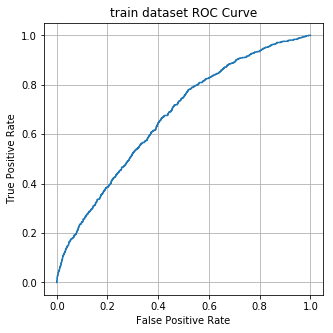

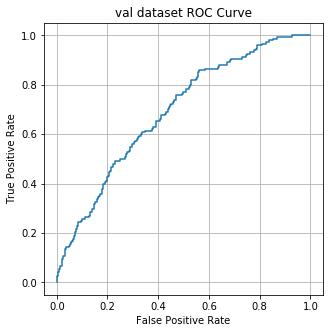

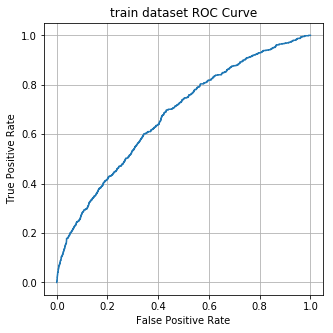

In [68]:
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    lr = LogisticRegression(random_state=8, C=0.01, tol=0.01)
    lr.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])
    lr_y_true, lr_y_pred, lr_y_prob = test_learner(
        lr, data_resample_val, title='val dataset')
    lr_y_true_t, _, lr_y_prob_t = test_learner(
        lr, data_resample_train, title='train dataset')

In [146]:
auc = get_auc(y_true, y_prob)
auc_t = get_auc(y_true_t, y_prob_t)
fpr, tpr, thresh = roc_curve(y_true, y_prob)
fpr_train, tpr_t, thresh_t = roc_curve(y_true_t, y_prob_t)
plt.figure(figsize=(5, 5))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='Validation dataset:{:.2f}'.format(auc))
plt.plot(fpr_train, tpr_t, label='Training dataset:{:.2f}'.format(auc_t))
plt.legend(loc='lower right')
# plt.show()
plt.savefig(os.path.join(ROC_PATH,'roc_{:.4f}.png'.format(auc)))

NameError: name 'y_true_t' is not defined

### SVC

In [70]:
from sklearn.svm import SVC, NuSVC

In [52]:
SVC?

auc:0.5
auc:0.5006195902824402
auc:0.5
auc:0.5013231635093689
auc:0.5
auc:0.5013231635093689
auc:0.5
auc:0.5007238388061523
auc:0.5
auc:0.5012964010238647


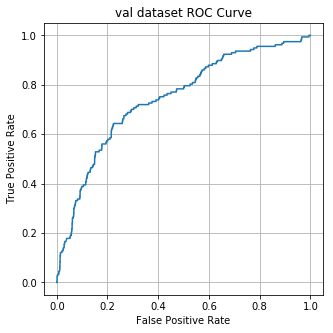

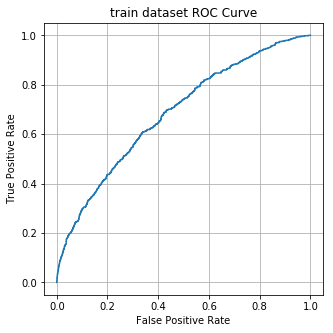

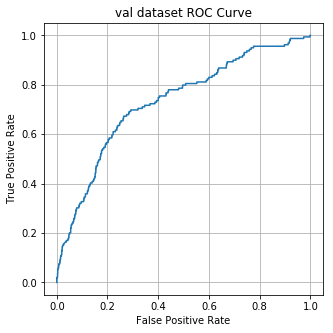

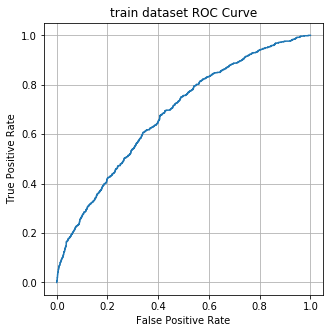

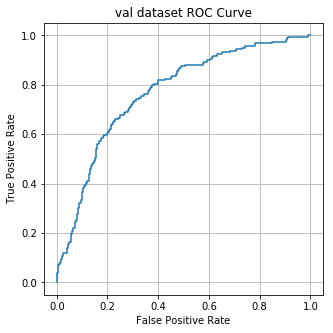

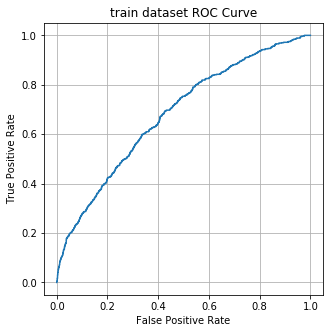

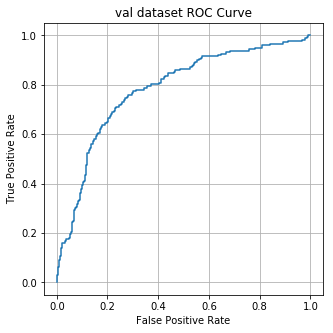

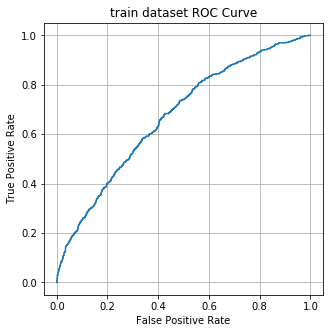

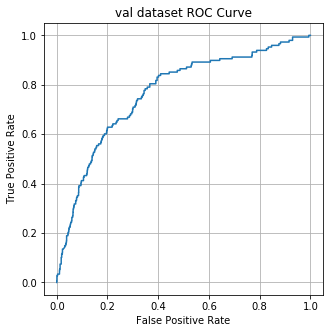

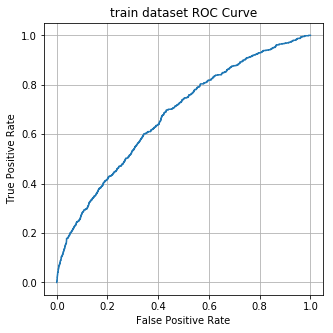

In [71]:
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    svc = SVC(C=0.1, kernel='rbf', degree=3, gamma='auto_deprecated', probability=True, random_state=6)
    svc.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

    svm_y_true, svm_y_pred, svm_y_prob=test_learner(svc, data_resample_val, title='val dataset')
    svm_y_true_t,_,svm_y_prob_t = test_learner(lr, data_resample_train, title='train dataset')

### GaussianNB

In [100]:
from sklearn.naive_bayes import GaussianNB

auc:0.782663106918335
auc:0.8172983527183533
auc:0.8716384768486023
auc:0.776905357837677
auc:0.7719298005104065
auc:0.8278051018714905
auc:0.8387806415557861
auc:0.8153061866760254
auc:0.7351744771003723
auc:0.7769432663917542


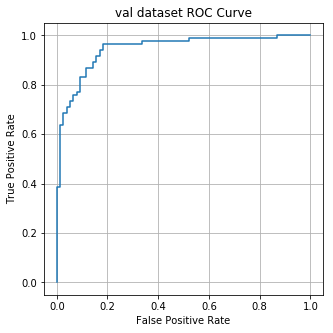

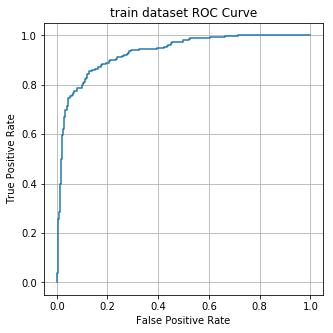

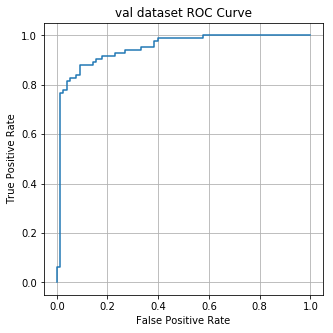

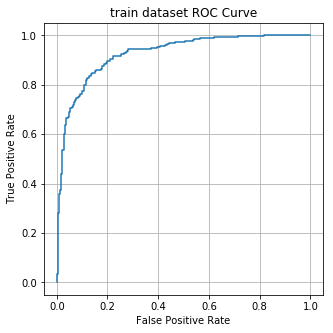

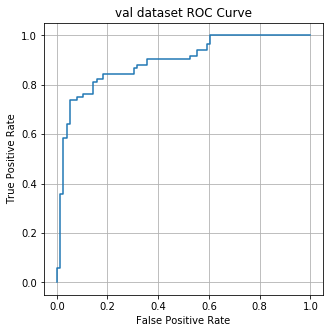

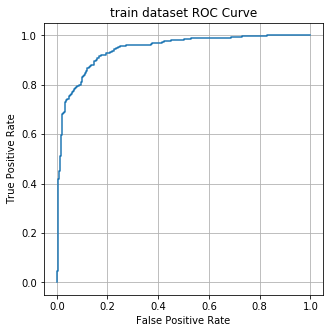

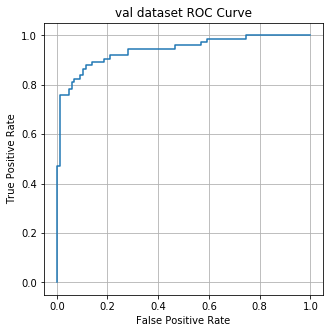

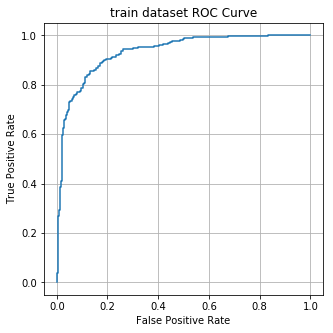

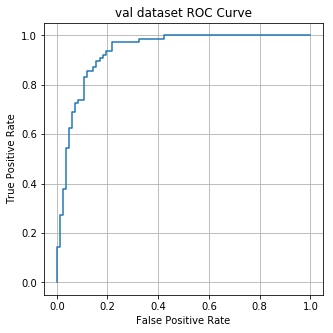

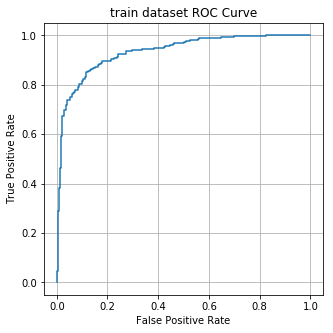

In [264]:
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    gnb = GaussianNB(var_smoothing=0.1)
    gnb.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

    gnb_y_true, gnb_y_pred, gnb_y_prob=test_learner(gnb, data_resample_val, title='val dataset')
    gnb_y_true_t,_,y_prob_t = test_learner(gnb, data_resample_train, title='train dataset')

## RF

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
from sklearn.model_selection import RandomizedSearchCV

In [31]:
distributions = {
    'n_estimators': list(range(60, 200)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(20,100)),
}
# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

data_resample_train = data_target_resample[train_index]
data_resample_val = data_target_resample[test_index]
rf = RandomForestClassifier(random_state=8)
clf = RandomizedSearchCV(rf, distributions, random_state=0, scoring='precision')
search = clf.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])
search.best_params_

{'n_estimators': 97, 'max_depth': 88, 'criterion': 'entropy'}

auc:0.5552380681037903
auc:1.0


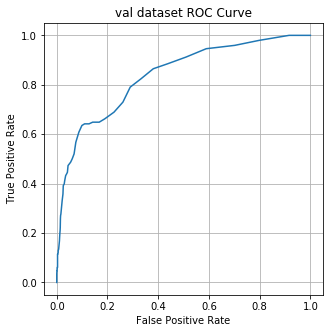

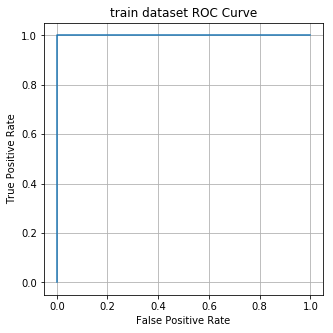

In [32]:
rf_y_true, rf_y_pred, rf_y_prob=test_learner(search, data_resample_val, title='val dataset')
rf_y_true_t,_,rf_y_prob_t = test_learner(search, data_resample_train, title='train dataset')

97 88
auc:0.9689407348632812
auc:1.0
97 88
auc:0.9624765515327454
auc:1.0
97 88
auc:0.8984962701797485
auc:1.0
97 88
auc:0.9758012890815735
auc:1.0
97 88
auc:0.9684712886810303
auc:1.0


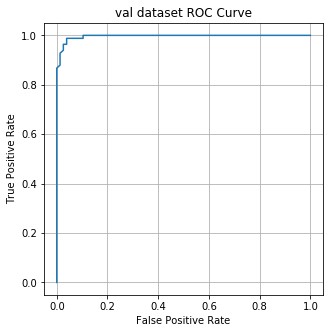

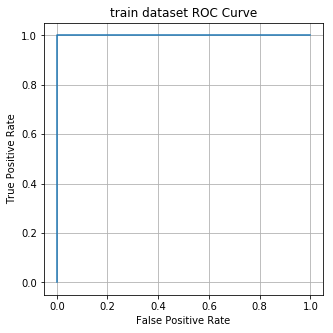

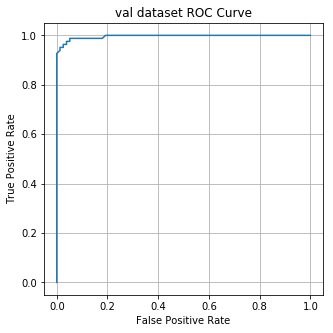

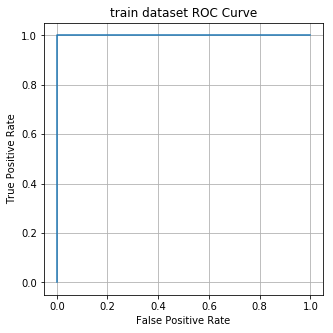

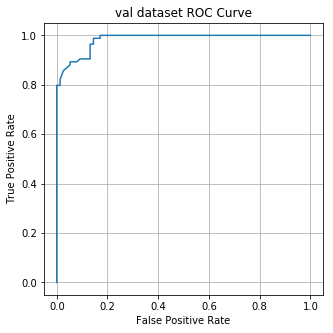

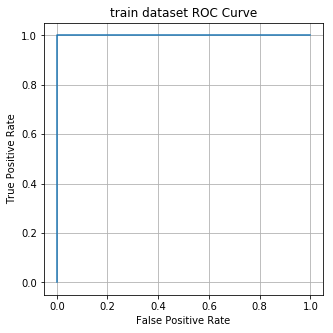

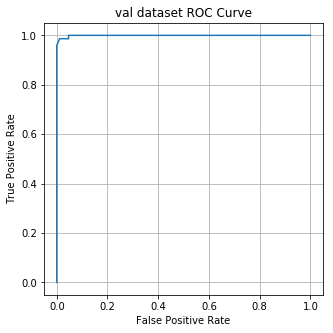

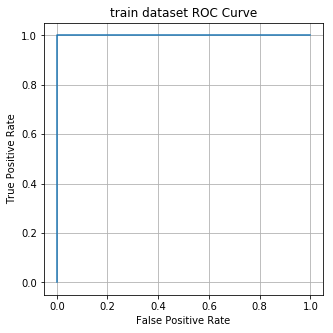

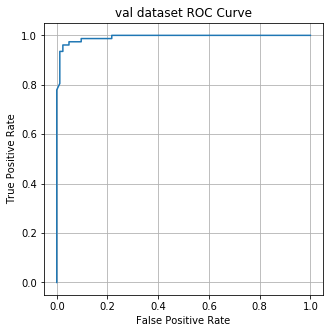

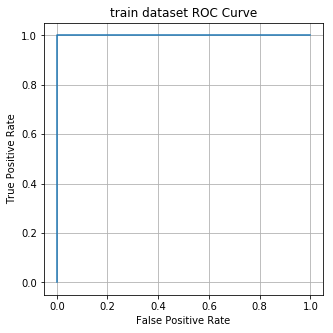

In [53]:
# for i in range(10,100):
# for j in range(22,100):
#66，32
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    rf = RandomForestClassifier(n_estimators=97, max_depth=88, random_state=8)
    print(rf.n_estimators, rf.max_depth)
    rf.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

    rf_y_true, rf_y_pred, rf_y_prob=test_learner(rf, data_resample_val, title='val dataset')
    rf_y_true_t,_,rf_y_prob_t = test_learner(rf, data_resample_train, title='train dataset')

In [54]:
_ = dataframe_xiepo_onehot.copy()

In [55]:
__ = _.pop('target')

In [56]:
y_pred_result = pd.DataFrame(rf.predict_proba(X=_))

In [57]:
y_pred_result.to_csv(r'G:\GIS\HuBei\A_rectangle\txt\result_rf_shoudong.csv')

In [58]:
rf.feature_importances_

array([0.02057423, 0.03182578, 0.01856377, 0.09314703, 0.02018796,
       0.01509164, 0.32054538, 0.01861463, 0.25266096, 0.06300473,
       0.0288926 , 0.01377783, 0.01912442, 0.        , 0.00219802,
       0.00077168, 0.00180844, 0.0016146 , 0.0015841 , 0.00140289,
       0.00209497, 0.00122851, 0.0393082 , 0.02867   , 0.00121664,
       0.        , 0.002091  ])

In [59]:
dataframe_xiepo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8716 entries, 0 to 8744
Data columns (total 16 columns):
aspect            8716 non-null object
slope             8716 non-null float64
plancur           8716 non-null float64
profile           8716 non-null float64
ndvi              8716 non-null float64
landuse           8716 non-null object
TRI               8716 non-null float64
dem_std           8716 non-null float64
dem_mean          8716 non-null float64
flowacc           8716 non-null float64
distance_HYDL     8716 non-null float64
distance_LRRDL    8716 non-null float64
distance_fault    8716 non-null float64
SPI               8716 non-null float64
TWI               8716 non-null float64
target            8716 non-null int64
dtypes: float64(13), int64(1), object(2)
memory usage: 1.1+ MB


In [60]:
landuse = sum(rf.feature_importances_[-5:])

In [61]:
aspect = sum(rf.feature_importances_[11:-5])

In [62]:
aspect

0.0456054631622632

In [63]:
data_resample_train[0][:]

array([ 3.04809758e+01, -5.90500590e-02, -6.29463040e-02,  7.20087312e-01,
        1.18681036e+00,  1.46617234e+02,  1.80245610e+03,  4.32652439e+01,
        3.41122582e+03,  6.21273655e+03,  7.22513361e+03,  1.99634258e+01,
        3.88003187e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

##  GradientBoosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

30 13
auc:0.5654401779174805
auc:0.996889591217041
30 13
auc:0.5905160307884216
auc:1.0
30 13
auc:0.5791999697685242
auc:1.0
30 13
auc:0.5783600807189941
auc:1.0
30 13
auc:0.6045200228691101
auc:0.9984662532806396


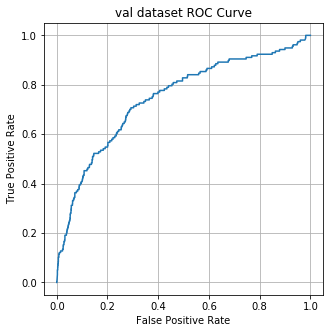

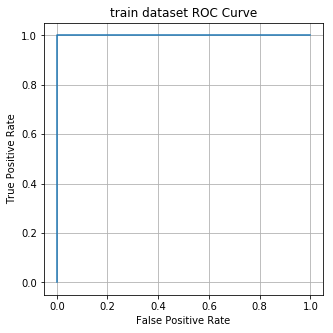

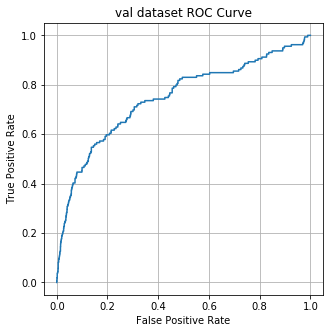

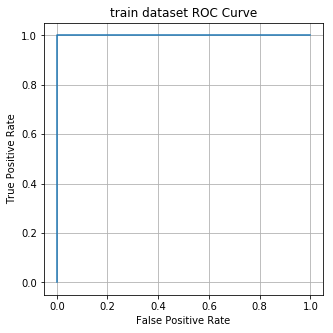

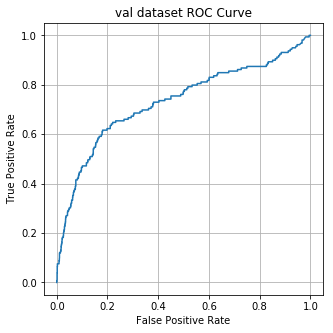

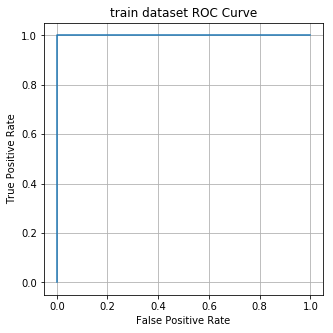

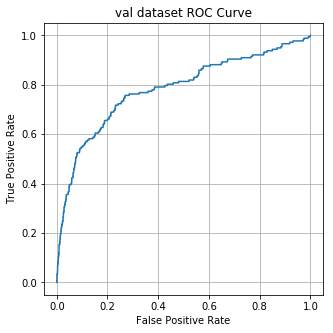

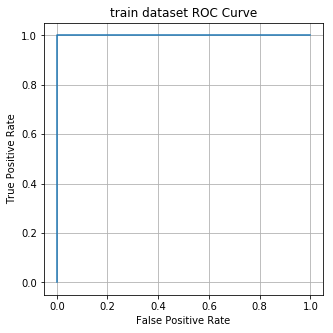

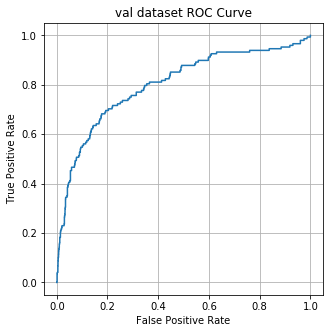

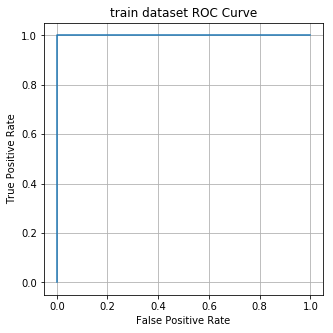

In [34]:
# aucs = np.zeros((50,50))
# for i in tqdm(range(3,50)):
#     for j in range(3,50):
for train_index, test_index in kf.split(data_target_resample):
    data_resample_train = data_target_resample[train_index]
    data_resample_val = data_target_resample[test_index]
    gb = GradientBoostingClassifier(n_estimators=30, max_depth=13, random_state=0)
    print(gb.n_estimators, gb.max_depth)
    gb.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])
    
    gb_y_true, gb_y_pred, gb_y_prob=test_learner(gb, data_resample_val, title='val dataset')
    gb_y_true_t,_,gb_y_prob_t = test_learner(gb, data_resample_train, title='train dataset')

# y_prob = gb.predict_proba(X=data_resample_val[:, :-1])[:, 1]
# y_true = data_resample_val[:, -1]
# aucs[i,j] = get_auc(y_true, y_prob)

## AdaBoost

In [1]:
from sklearn.ensemble import AdaBoostClassifier

In [101]:
algorithm_ada = ['SAMME', 'SAMME.R']
base_estimators = [
#     MLPClassifier(hidden_layer_sizes=(64), activation='relu', random_state=0,
#                   solver='sgd', alpha=1e-5, max_iter=500, early_stopping=True),
    DecisionTreeClassifier(
        criterion='gini', max_depth=14, random_state=8),
    ExtraTreeClassifier(criterion='gini', max_depth=15, random_state=8),
    LogisticRegression(C=1, tol = 1, random_state=0),
#     KNeighborsClassifier(n_neighbors=70),
    SVC(C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', probability=True,),
    GaussianNB(var_smoothing=0.001),
]

In [4]:
AdaBoostClassifier?

50 <class 'sklearn.tree.tree.DecisionTreeClassifier'> SAMME
auc:0.5391958355903625
auc:1.0
50 <class 'sklearn.tree.tree.DecisionTreeClassifier'> SAMME
auc:0.5484205484390259
auc:1.0
50 <class 'sklearn.tree.tree.DecisionTreeClassifier'> SAMME
auc:0.5503025054931641
auc:1.0
50 <class 'sklearn.tree.tree.DecisionTreeClassifier'> SAMME
auc:0.538270890712738
auc:1.0
50 <class 'sklearn.tree.tree.DecisionTreeClassifier'> SAMME
auc:0.5386596322059631
auc:1.0
50 <class 'sklearn.tree.tree.ExtraTreeClassifier'> SAMME
auc:0.5564137697219849
auc:1.0
50 <class 'sklearn.tree.tree.ExtraTreeClassifier'> SAMME
auc:0.5540785193443298
auc:1.0
50 <class 'sklearn.tree.tree.ExtraTreeClassifier'> SAMME
auc:0.529236912727356
auc:1.0
50 <class 'sklearn.tree.tree.ExtraTreeClassifier'> SAMME
auc:0.5514373183250427
auc:1.0
50 <class 'sklearn.tree.tree.ExtraTreeClassifier'> SAMME
auc:0.5579894781112671
auc:1.0
50 <class 'sklearn.linear_model.logistic.LogisticRegression'> SAMME
auc:0.5025545954704285
auc:0.5021747946

ValueError: BaseClassifier in AdaBoostClassifier ensemble is worse than random, ensemble can not be fit.

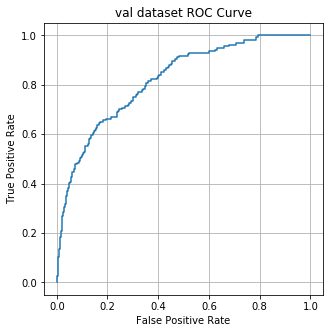

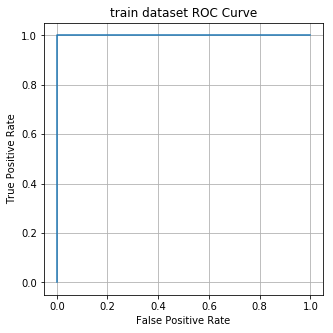

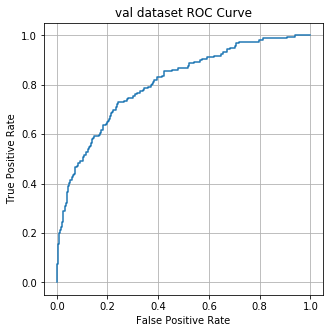

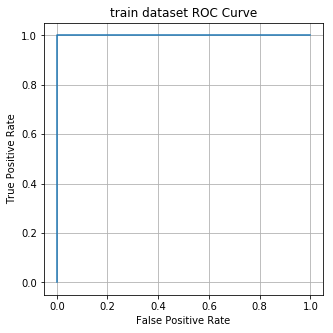

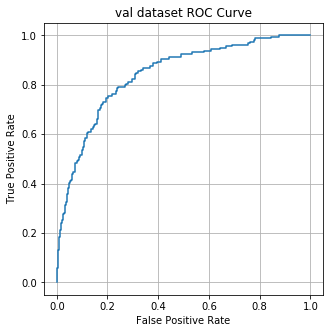

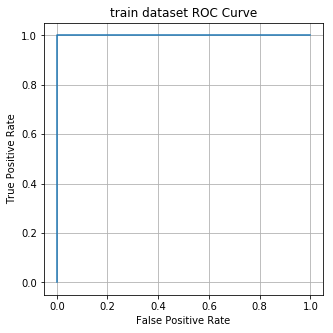

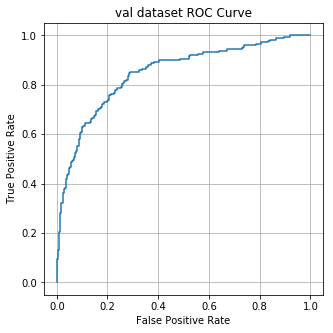

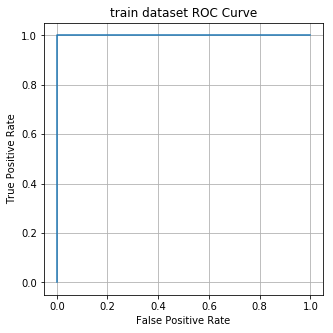

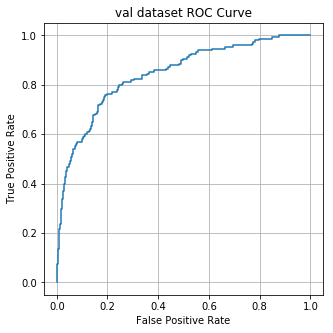

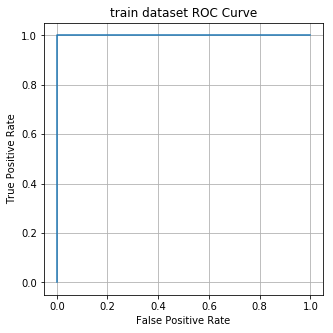

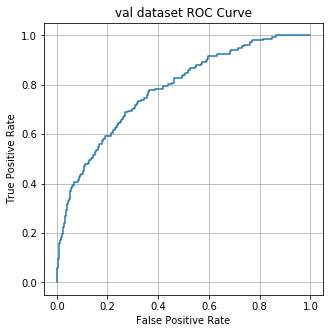

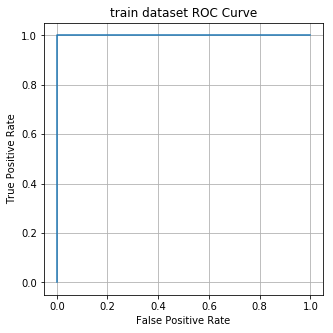

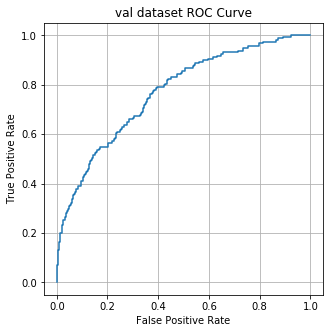

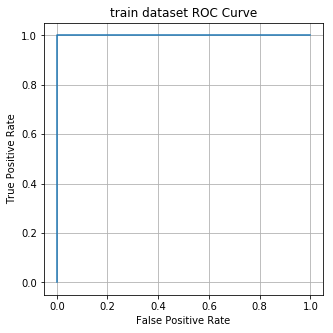

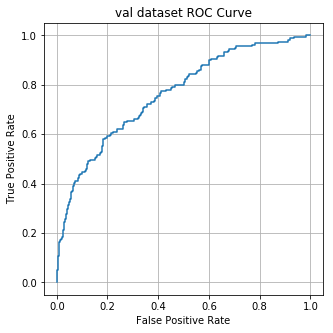

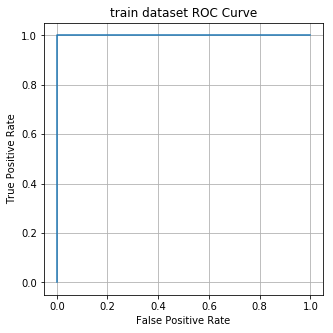

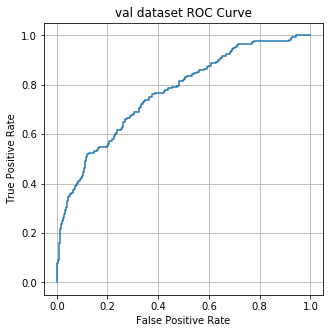

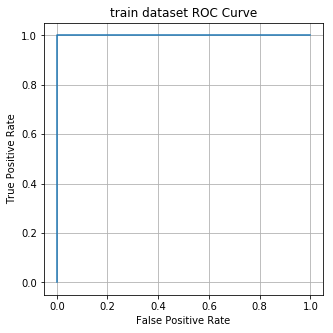

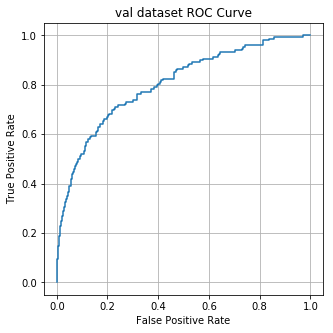

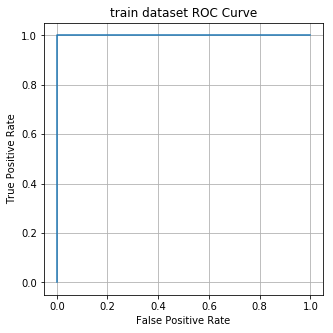

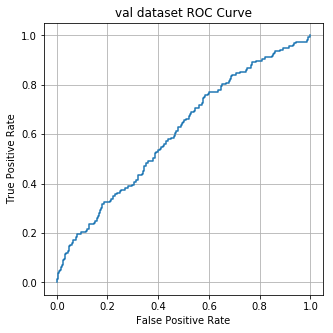

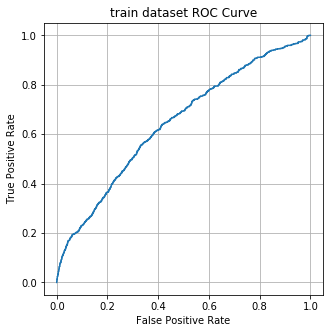

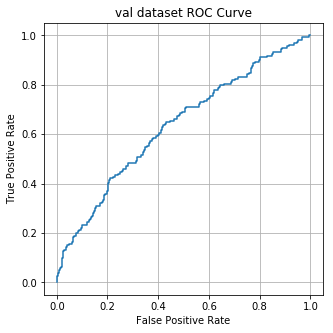

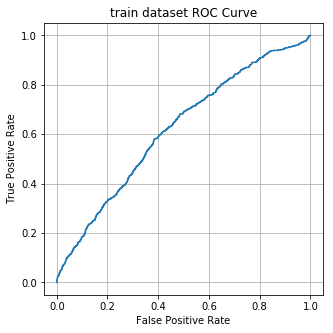

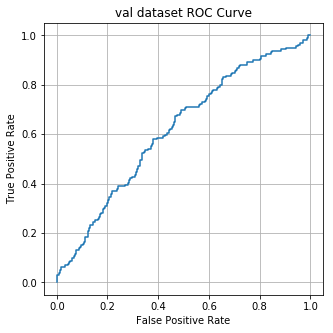

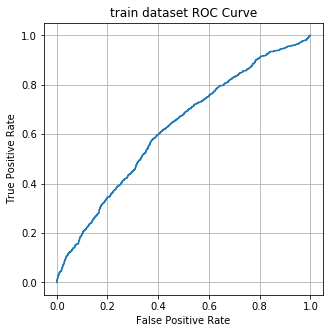

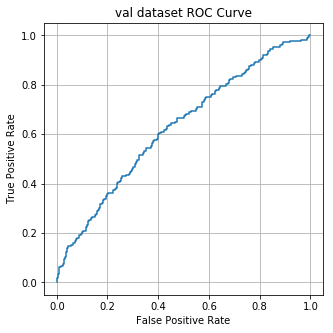

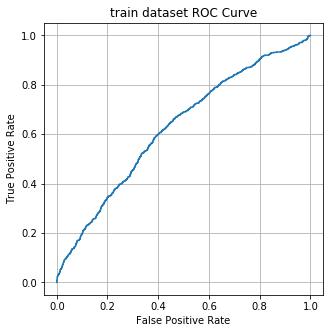

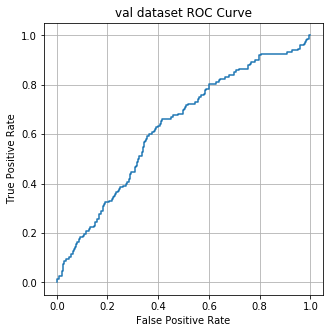

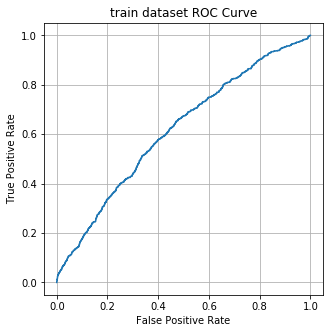

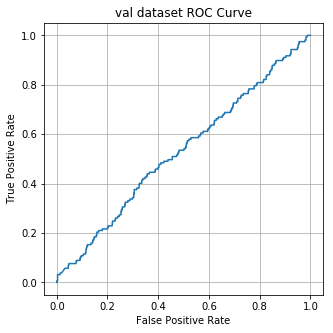

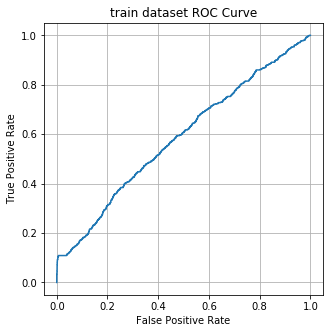

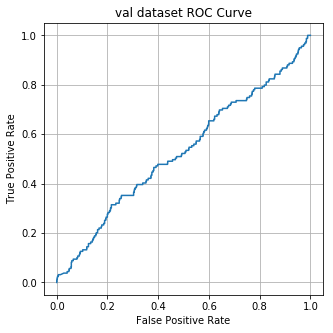

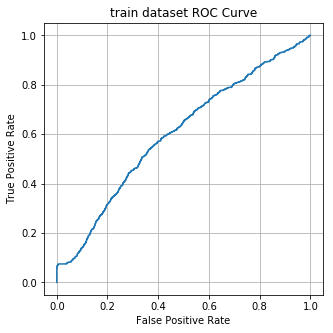

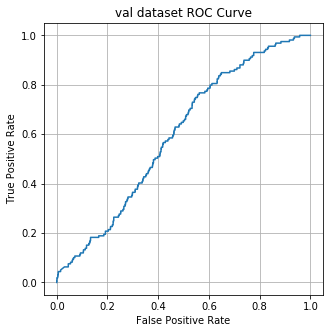

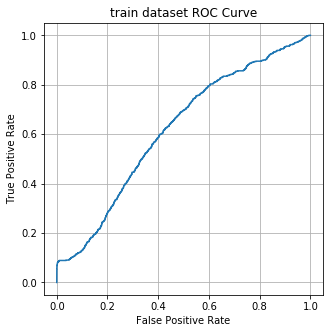

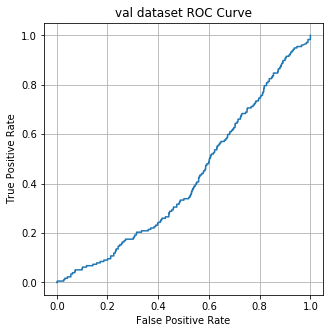

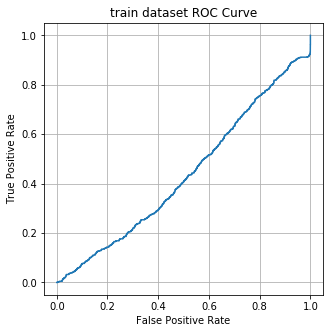

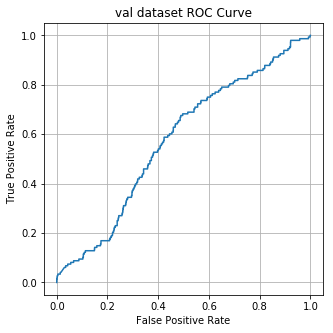

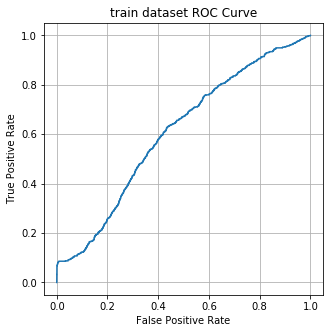

In [102]:
# for alg in algorithm_ada:
from time import time
start = time()
for estimator in base_estimators:
#         for n_est in range(90, 131):
# 101，DT，SAMME：0.8325
# 101, ET, samme: 0.8314
    for train_index, test_index in kf.split(data_target_resample):
        data_resample_train = data_target_resample[train_index]
        data_resample_val = data_target_resample[test_index]
        ada = AdaBoostClassifier(base_estimator=estimator, n_estimators=50,
                                 learning_rate=1.0, algorithm=algorithm_ada[0], random_state=8)
        print(ada.n_estimators, ada.base_estimator.__class__, ada.algorithm)
        ada.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

        ada_y_true, ada_y_pred, ada_y_prob=test_learner(ada, data_resample_val, title='val dataset')
        ada_y_true_t,_,ada_y_prob_t = test_learner(ada, data_resample_train, title='train dataset')
end = time()
tttttt = start - end
print(tttttt)

## Bagging

In [103]:
bagging_base_estimators = [
#     MLPClassifier(hidden_layer_sizes=(64), activation='relu', random_state=0,
#                   solver='sgd', alpha=1e-5, max_iter=500, early_stopping=True),
    DecisionTreeClassifier(
        criterion='gini', max_depth=14, random_state=8),
    ExtraTreeClassifier(criterion='gini', max_depth=15, random_state=8),
    LogisticRegression(C=0.1, tol = 1, random_state=0),
    SVC(C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', probability=True,),
#     KNeighborsClassifier(n_neighbors=70),
    GaussianNB(var_smoothing=0.1),
]

17 <class 'sklearn.tree.tree.DecisionTreeClassifier'>
auc:0.5943835377693176
auc:0.8849144577980042
17 <class 'sklearn.tree.tree.DecisionTreeClassifier'>
auc:0.5823565721511841
auc:0.9125575423240662
17 <class 'sklearn.tree.tree.DecisionTreeClassifier'>
auc:0.5754478573799133
auc:0.8891565799713135
17 <class 'sklearn.tree.tree.DecisionTreeClassifier'>
auc:0.5899787545204163
auc:0.9001666307449341
17 <class 'sklearn.tree.tree.DecisionTreeClassifier'>
auc:0.5978330969810486
auc:0.9093509912490845
17 <class 'sklearn.tree.tree.ExtraTreeClassifier'>
auc:0.5149783492088318
auc:0.6220839619636536
17 <class 'sklearn.tree.tree.ExtraTreeClassifier'>
auc:0.514145016670227
auc:0.6076443195343018
17 <class 'sklearn.tree.tree.ExtraTreeClassifier'>
auc:0.5210655927658081
auc:0.6473469138145447
17 <class 'sklearn.tree.tree.ExtraTreeClassifier'>
auc:0.5141242742538452
auc:0.6067415475845337
17 <class 'sklearn.tree.tree.ExtraTreeClassifier'>
auc:0.5199567675590515
auc:0.6395705342292786
17 <class 'sklea

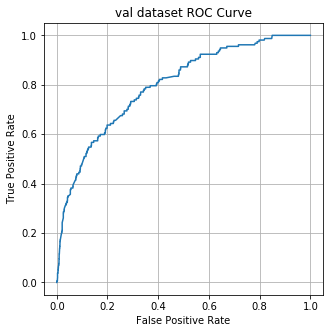

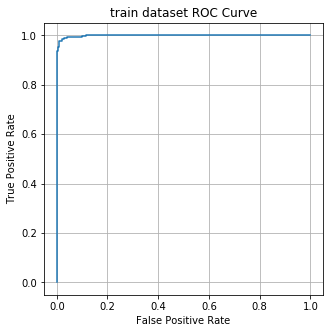

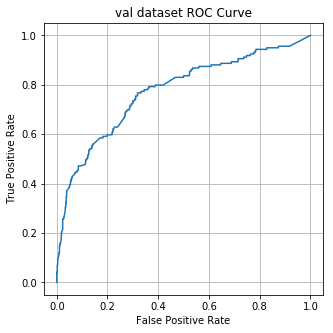

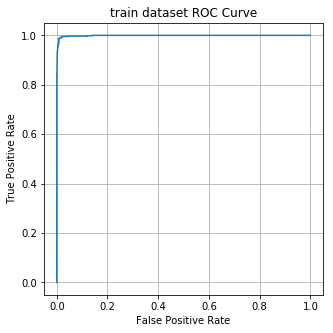

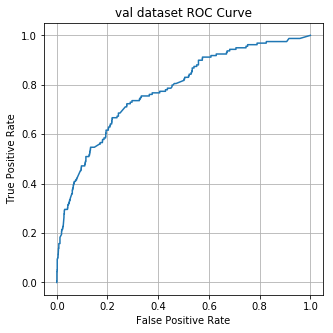

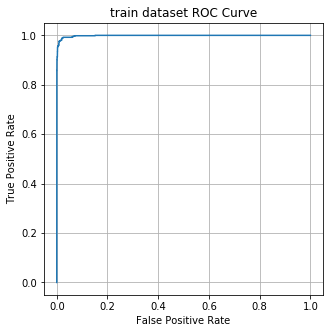

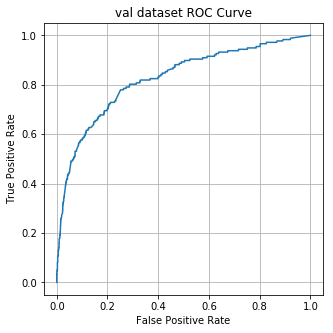

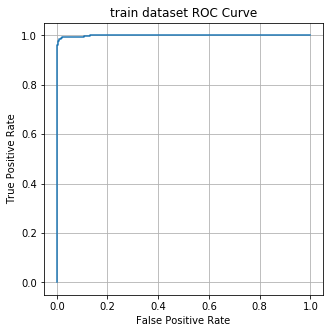

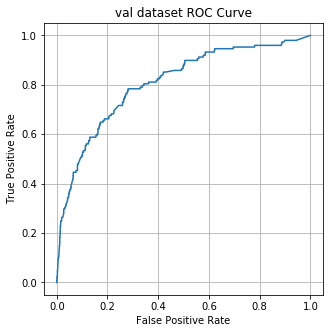

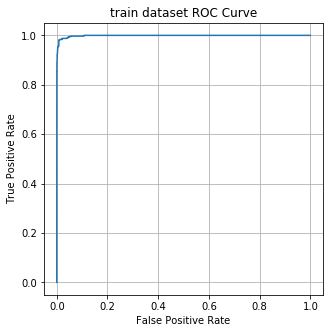

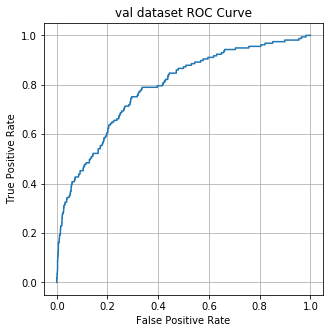

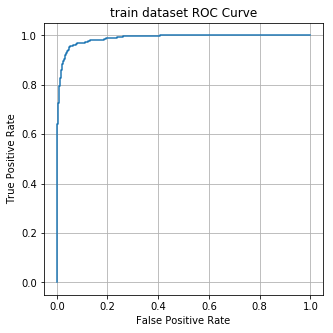

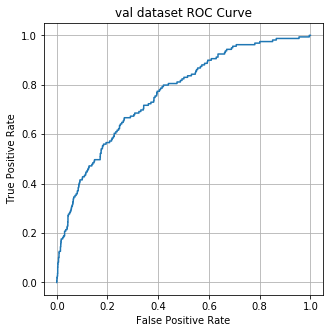

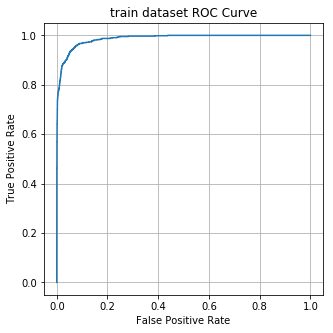

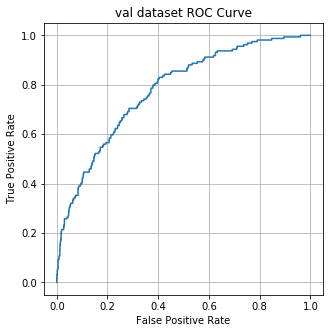

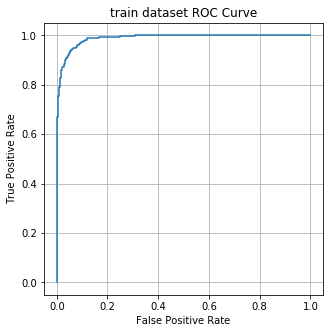

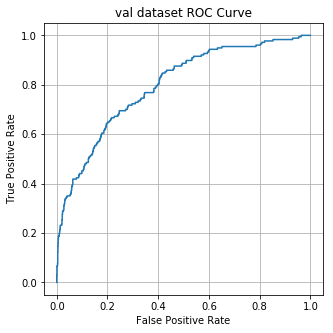

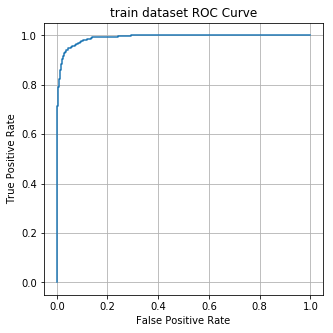

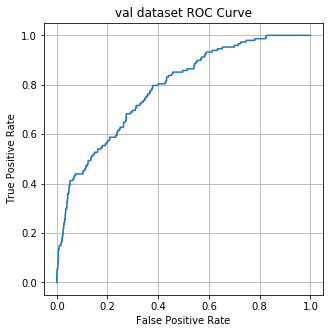

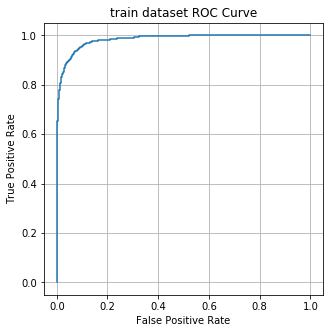

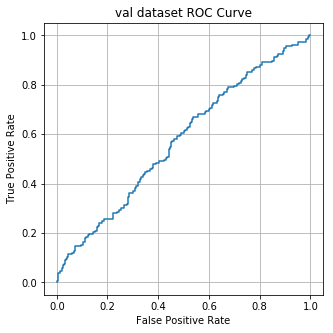

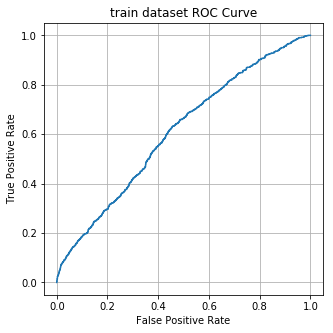

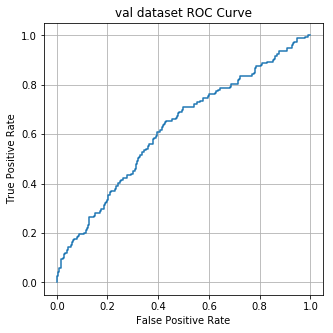

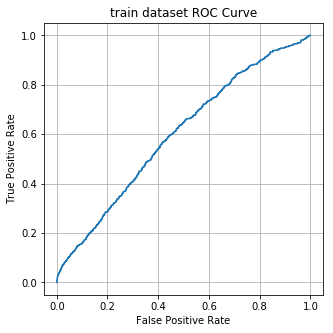

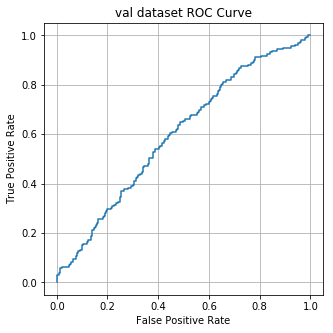

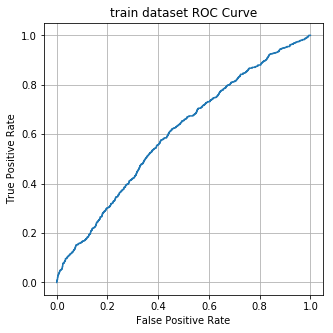

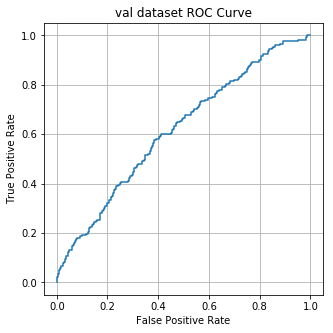

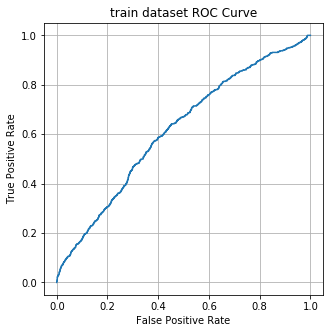

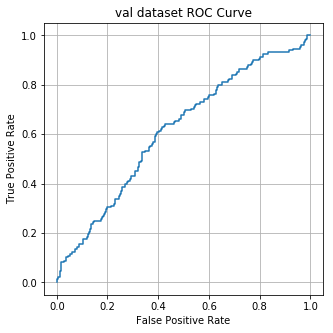

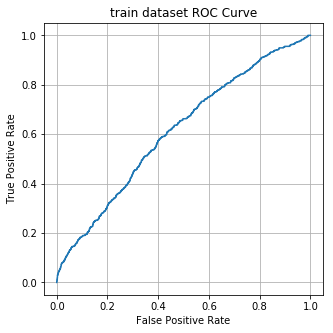

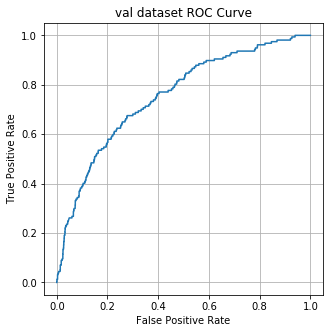

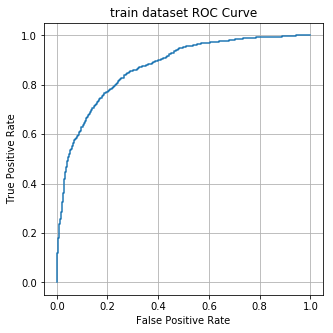

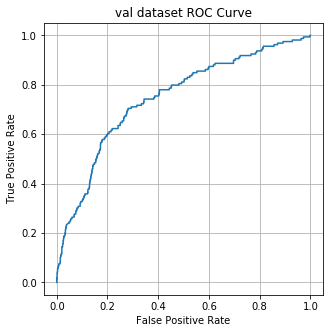

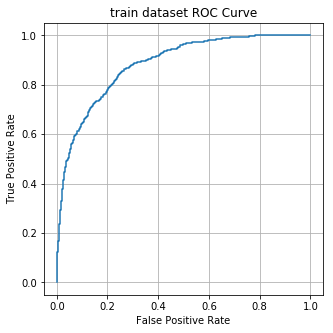

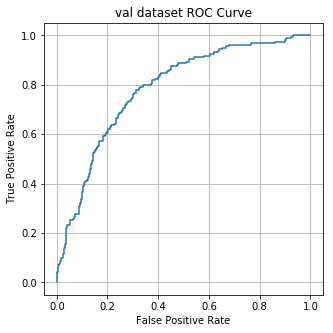

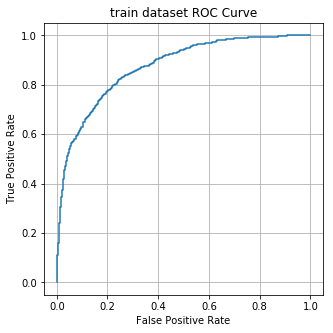

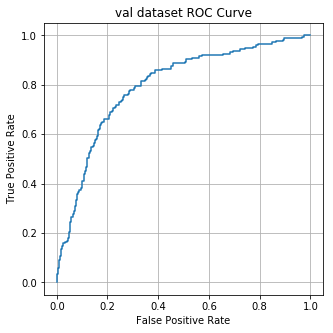

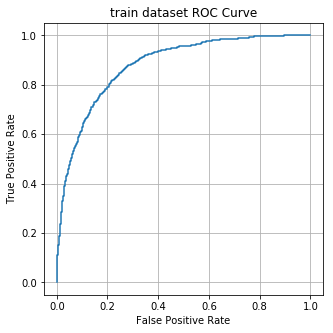

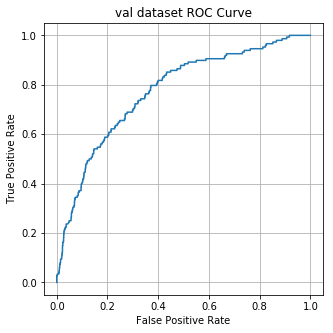

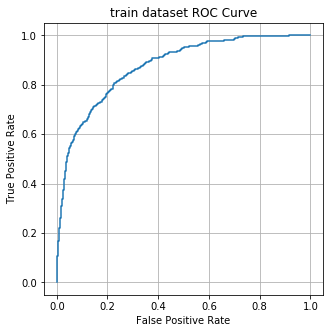

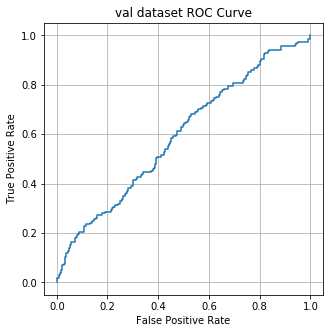

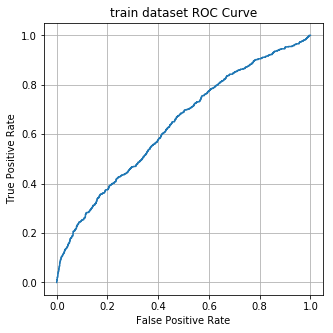

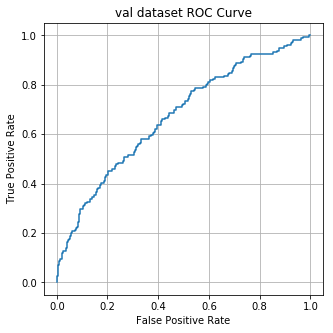

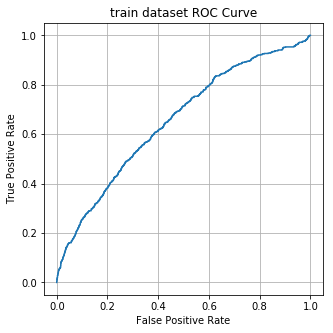

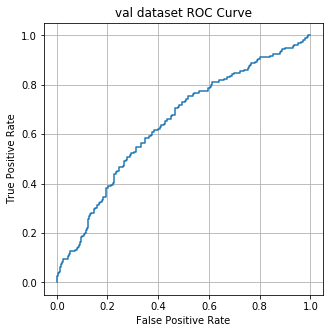

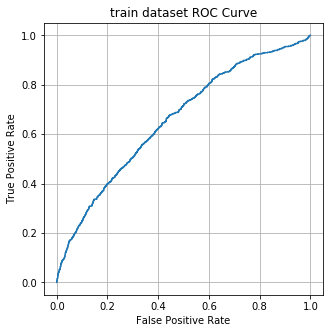

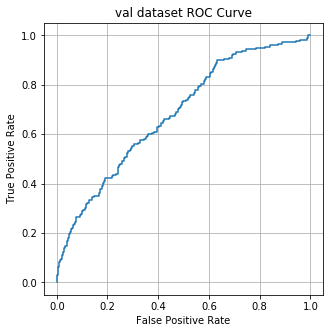

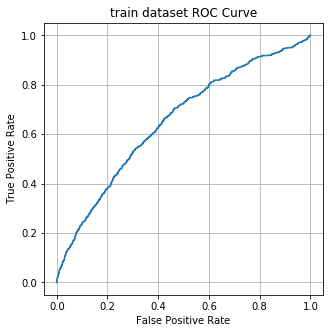

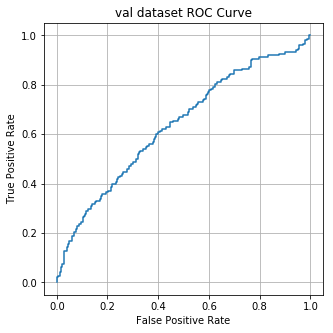

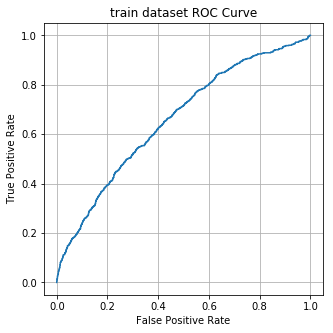

In [104]:
from sklearn.ensemble import BaggingClassifier

start = time()
for estimator in bagging_base_estimators:
#     for n_est in range(1, 60):
    for train_index, test_index in kf.split(data_target_resample):
        data_resample_train = data_target_resample[train_index]
        data_resample_val = data_target_resample[test_index]
        bagging = BaggingClassifier(base_estimator=estimator, n_estimators=17,
                                    random_state=8)
        print(bagging.n_estimators, bagging.base_estimator.__class__)
        bagging.fit(X=data_resample_train[:, :-1], y=data_resample_train[:, -1])

        bag_y_true, bag_y_pred, bag_y_prob = test_learner(bagging, data_resample_val, title='val dataset')
        bag_y_true_t,_,bag_y_prob_t = test_learner(bagging, data_resample_train, title='train dataset')
        
tttt = time() - start
print(tttt)